In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import plotly.graph_objs as go
import plotly.express as px
import warnings
import plotly.io as pio
import nltk
from nltk.corpus import stopwords
import tensorflow_hub as hub
import json
import re

from scipy.stats import ttest_ind, mannwhitneyu
from plotly.subplots import make_subplots
from scipy import stats
from helpers import find_duplicates
from data_loading import load_dataset
from scipy.stats import ks_2samp
from scipy.stats import f_oneway
from collections import Counter
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

In [2]:
# set color blind friendly palette
sns.set_palette("colorblind")

# Project Milestone 2

## Abstract
Lights, Camera, Analysis! Roll out the red carpet, because we're diving into the world of movies, where popcorn isn't the only thing popping – so are economic trends! Ever wondered if classic blockbusters like "Gone with the Wind" would give modern marvels a run for their money if we time-travel their earnings to today? Spoiler alert: when you toss inflation into the mix, some oldies might just top the charts. Zooming out, our world's economic rollercoaster seems to have a VIP seat for the movie industry. Does a country's wallet size, measured in GDP, dictate if its films will be box office hits or misses? Interestingly, this cinematic puzzle might have more twists than a thriller movie! Grab your 3D glasses, as we embark on this data-driven adventure, blending the art of cinema with the science of analysis!

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Data-Processing-" data-toc-modified-id="Data-Processing--2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Processing <a class="anchor" id="first-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#Q1:-Inflation-and-Trends-in-the-Movie-Industry" data-toc-modified-id="Q1:-Inflation-and-Trends-in-the-Movie-Industry-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Q1: Inflation and Trends in the Movie Industry</a></span></li><li><span><a href="#Q2:-Global-Economic-Growth-and-its-Influence-on-the-Movie-Industry" data-toc-modified-id="Q2:-Global-Economic-Growth-and-its-Influence-on-the-Movie-Industry-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Q2: Global Economic Growth and its Influence on the Movie Industry</a></span></li><li><span><a href="#Q3:-Determinants-of-a-Movie's-Financial-Success" data-toc-modified-id="Q3:-Determinants-of-a-Movie's-Financial-Success-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Q3: Determinants of a Movie's Financial Success</a></span></li><li><span><a href="#Q4:-Influence-of-Global-Events-on-the-Movie-Industry" data-toc-modified-id="Q4:-Influence-of-Global-Events-on-the-Movie-Industry-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Q4: Influence of Global Events on the Movie Industry</a></span></li><li><span><a href="#Q5:-Correlation-Between-Movie-Content-and-Financial-Success" data-toc-modified-id="Q5:-Correlation-Between-Movie-Content-and-Financial-Success-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Q5: Correlation Between Movie Content and Financial Success</a></span></li><li><span><a href="#Q6:-Predictive-Analysis-of-Movie-Revenue" data-toc-modified-id="Q6:-Predictive-Analysis-of-Movie-Revenue-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Q6: Predictive Analysis of Movie Revenue</a></span></li></ul></div>

____________________________

## Data Processing <a class="anchor" id="first-bullet"></a>

### Loading the Data

In [3]:
# load the datasets as pandas dataframes
movie_metadata = load_dataset("movie_metadata")
movie_budget = load_dataset("movie_budget")
imdb_ratings = load_dataset("imdb_ratings")
imdb_basics = load_dataset("imdb_basics")
cpi_data = load_dataset("cpi_data")
gdp_data = load_dataset("gdp_data")
plots = load_dataset("plot_summaries")

Loading dataset: movie_metadata
Loading dataset: movie_budget
Loading dataset: imdb_ratings
Loading dataset: imdb_basics
Loading dataset: cpi_data
Loading dataset: gdp_data
Loading dataset: plot_summaries


In [4]:
# print the shapes of the datasets
print("Movie Metadata Shape: ", movie_metadata.shape)
print("TMDB Budget Shape: ", movie_budget.shape)
print("IMDB Ratings Shape: ", imdb_ratings.shape)
print("IMDB Basics Shape: ", imdb_basics.shape)
print("CPI Data Shape: ", cpi_data.shape)
print("GDP Data Shape: ", gdp_data.shape)

Movie Metadata Shape:  (81741, 9)
TMDB Budget Shape:  (45466, 10)
IMDB Ratings Shape:  (1368131, 3)
IMDB Basics Shape:  (10309011, 9)
CPI Data Shape:  (266, 68)
GDP Data Shape:  (266, 68)


### Data Handling

In this section we will clean and preprocess seven datasets: `plots`, `movie_metadata`, `movie_budget`, `imdb_ratings`, `imdb_basics`, `us_cpi`, and `us_gdp`, ensuring the removal of NaN values in order to prepare the data for accurate analysis. At the end we will have merged our six datasets into one single `movie` dataset, enriched with additional features gathered from each individual dataset.

##### Dataset: `plots`

Merge the `plots` dataset with `movie_metadata` before cleaning the latter, so we retain maximum number of movies with plots.

In [5]:
# merge the datasets
movies_with_plots = pd.merge(movie_metadata, plots, on="wikipedia_id")

In [6]:
# extract the year from the release date
movies_with_plots["year"] = movies_with_plots["release_date"].str[:4]

In [7]:
display(movies_with_plots.head())
print(movies_with_plots.shape)

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,plot,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",2001
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...,1987
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra...",1983
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns...",2002
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a...",1997


(42204, 11)


##### Dataset: `movie_metadata`

The "CMU Movie Summary Corpus" provides an dataset of movie metadata containing 81,741 movies, extracted from the November 4, 2012 dump of Freebase. Every movie has details including movie box office revenue, genre, release date, runtime, and language.

In [8]:
display(movie_metadata.head(5))
print(movie_metadata.shape)

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


(81741, 9)


In [9]:
initial_movie_shape = movie_metadata.shape

print(
    "Total amount of rows that contain a NaN value: ",
    movie_metadata.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": movie_metadata.isna().sum(),
        "nan_percentage": movie_metadata.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  73498


,nan_sum,nan_percentage
wikipedia_id,0,0.000000
freebase_movie_id,0,0.000000
title,0,0.000000
release_date,6902,8.443743
revenue,73340,89.722416
runtime,20450,25.018045
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


We are mainly interested in the box office revenue, so we will drop all rows where this value is missing.
Additionally, we want to merge the CMU movies dataset with the IMDB dataset on title, year and runtime, so we need to drop the rows with missing values in these columns as well. Finally, we extract the year from the movie release date.

In [10]:
# drop all rows with missing values in the revenue, release_date or runtime column
movie_metadata = movie_metadata.dropna(subset=["revenue", "release_date", "runtime"])

# make a column year extracting the year from the release date
movie_metadata["year"] = movie_metadata["release_date"].str[:4]

We need to check for duplicates in order to only have unique movies in the dataset.

In [11]:
# see if there are any duplicates in the movie metadata dataset
find_duplicates(movie_metadata, ["title", "release_date", "runtime"])

"No duplicates found in the specified columns: ['title', 'release_date', 'runtime']"

In [12]:
print(
    "Percentage of rows dropped after cleaning: ",
    ((1 - movie_metadata.shape[0] / initial_movie_shape[0]) * 100),
)

Percentage of rows dropped after cleaning:  89.91570937473239


Approximately 90% of the initial movie dataset was filtered out, resulting in a selection of 8,243 movies. This provides a sufficient basis for our intended analysis.


In [13]:
# the dataset after cleaning
display(movie_metadata.head(5))
print(movie_metadata.shape)

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999


(8243, 10)


##### Dataset: `movie_budget`

We will use this external dataset to append the budget of the movies to our main movie dataset. This would help us to better understand the correlation between the budget and the revenue of the movies and explore the profitability of the movies.

In [14]:
display(movie_budget.head(5))
print(movie_budget.shape)

,budget,imdb_id,original_title,popularity,release_date,revenue,runtime,title,vote_average,vote_count
0,30000000,tt0114709,Toy Story,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0
1,65000000,tt0113497,Jumanji,17.015539,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0
2,0,tt0113228,Grumpier Old Men,11.7129,1995-12-22,0.0,101.0,Grumpier Old Men,6.5,92.0
3,16000000,tt0114885,Waiting to Exhale,3.859495,1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0
4,0,tt0113041,Father of the Bride Part II,8.387519,1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,173.0


(45466, 10)


It is important to note that this dataset contains some budget values that are either zero or near-zero, which are realistically improbable. To maintain data integrity, these entries will be excluded from our analysis. According to [movieweb](https://movieweb.com/cheapest-movies-ever-made/#tarnation-218-32), an exceptional case in low-budget filmmaking is the documentary [Tarnation](https://en.wikipedia.org/wiki/Tarnation_(2003_film)) directed by Jonathan Caouette, with a budget of just \\$218.32. Consequently, we will exclude movies with reported budgets below \\$218 from our analysis, considering them likely to be inaccuracies or data entry errors. 

In [15]:
# the nans in this dataset are represented as "\\N" and <NAN>, so we need to replace them with NaN
movie_budget = movie_budget.replace("\\N", np.nan)
movie_budget = movie_budget.replace("<NAN>", np.nan)

# convert to float, non-convertible values become NaN
movie_budget["budget"] = pd.to_numeric(movie_budget["budget"], errors="coerce")

# replace budget values < $218 with NaN
movie_budget.loc[movie_budget["budget"] < 218, "budget"] = np.nan

print(
    "Total amount of rows that contain a NaN value: ",
    movie_budget.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": movie_budget.isna().sum(),
        "nan_percentage": movie_budget.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  36772


,nan_sum,nan_percentage
budget,36758,80.847226
imdb_id,17,0.037391
original_title,0,0.000000
popularity,5,0.010997
release_date,87,0.191352
revenue,6,0.013197
runtime,263,0.578454
title,6,0.013197
vote_average,6,0.013197
vote_count,6,0.013197


We will be merging this dataset with the imdb datasets by imdb_id, so we drop all of the rows where this value is NaN. Additionally, we drop the columns that overlap with our initial movie_metadata dataset. Finally, since we are interested in populating the `movie_metadata` dataset with the budget, we drop all of the rows where this value is missing.

In [16]:
# drop all rows with missing value in the imdb_id column
movie_budget = movie_budget.dropna(subset=["imdb_id"])

# drop the columns which are present in movie_metadata
common_columns = movie_budget.columns.intersection(movie_metadata.columns)
movie_budget = movie_budget.drop(columns=common_columns)

# drop all rows with missing value in the budget column
movie_budget.dropna(subset=["budget"], inplace=True)

We need to check for duplicates in order to only have unique movies in the dataset.

In [17]:
# see if there are any duplicates in the movie budget dataset
find_duplicates(movie_budget, ["imdb_id"])

,budget,imdb_id,original_title,popularity,vote_average,vote_count
26625,10000000.0,tt0100361,The Phantom of the Opera,0.43849,5.0,3.0
9576,10000000.0,tt0100361,The Phantom of the Opera,0.441872,5.0,3.0
33743,26000000.0,tt0157472,Clockstoppers,4.920175,4.9,90.0
5130,26000000.0,tt0157472,Clockstoppers,5.373623,4.9,89.0
4114,16000000.0,tt0235679,Pokémon 3: The Movie,10.264597,6.0,143.0
44821,16000000.0,tt0235679,Pokémon 3: The Movie,6.480376,6.0,144.0
5865,30000000.0,tt0270288,Confessions of a Dangerous Mind,11.331072,6.6,281.0
33826,30000000.0,tt0270288,Confessions of a Dangerous Mind,7.645827,6.6,281.0
10419,1600000.0,tt0454792,Bubble,3.185256,6.4,36.0
12066,1600000.0,tt0454792,Bubble,3.008299,6.4,36.0


As we can see there are some movies that are present more than once, so we need to exclude them from the dataset.

In [18]:
# drop duplicates since there are some movies with the same imdb id
movie_budget = movie_budget.drop_duplicates(subset=["imdb_id"])

In [19]:
# the dataset after cleaning
display(movie_budget.head(5))
print(movie_budget.shape)

,budget,imdb_id,original_title,popularity,vote_average,vote_count
0,30000000.0,tt0114709,Toy Story,21.946943,7.7,5415.0
1,65000000.0,tt0113497,Jumanji,17.015539,6.9,2413.0
3,16000000.0,tt0114885,Waiting to Exhale,3.859495,6.1,34.0
5,60000000.0,tt0113277,Heat,17.924927,7.7,1886.0
6,58000000.0,tt0114319,Sabrina,6.677277,6.2,141.0


(8697, 6)


##### Dataset: `imdb_basics`

The `imdb_basics`("title.basics.tsv.gz") dataset contains information about different types of movies and TV shows. This dataset is used as a connection between `movie_metadata` and `imdb_ratings dataset`.

In [20]:
display(imdb_basics.head(5))
print(imdb_basics.shape)

,imdb_id,title_type,primary_title,title,is_adult,year,end_year,runtime,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


(10309011, 9)


Convert all of the missing values to be the same format (NaN)

In [21]:
# the nans in this dataset are represented as "\\N" and <NAN>, so we need to replace them
imdb_basics = imdb_basics.replace("\\N", np.nan)
imdb_basics = imdb_basics.replace("<NAN>", np.nan)

print(
    "Total amount of rows that contain a NaN value: ",
    imdb_basics.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": imdb_basics.isna().sum(),
        "nan_percentage": imdb_basics.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  10255916


,nan_sum,nan_percentage
imdb_id,0,0.000000
title_type,0,0.000000
primary_title,17,0.000165
title,17,0.000165
is_adult,1,0.000010
year,1381604,13.401906
end_year,10194381,98.888060
runtime,7203485,69.875617
genres,460237,4.464415


First, the invalid values (those that are not numerical) in the runtime column are converted to NaN. Next, we drop all rows with missing values in the title, year and runtime columns, since we are joining the `movie_metadata` on these keys later. Additionally we drop the column end year, since it has 98.8\\% missing values, and the genre column since it is already present in `movie_metadata`. 

In [22]:
# convert runtime to float so it matches runtime from movie_metadata, the non-convertable values in runtime to NaN
imdb_basics["runtime"] = pd.to_numeric(imdb_basics["runtime"], errors="coerce").astype(
    float
)

# drop all rows with missing value in the title, year or runtime column
imdb_basics = imdb_basics.dropna(subset=["title", "year", "runtime"])

# drop the columns which are present in movie_metadata and column end_year since it is almost always NaN
imdb_basics = imdb_basics.drop(columns=["end_year", "genres"])

We need to check for duplicates in order to only have unique movies in the dataset.

In [23]:
find_duplicates(imdb_basics, ["imdb_id"])

"No duplicates found in the specified columns: ['imdb_id']"

In [24]:
display(imdb_basics.head(5))
print(imdb_basics.shape)

,imdb_id,title_type,primary_title,title,is_adult,year,runtime
0,tt0000001,short,Carmencita,Carmencita,0,1894,1.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1.0


(2909431, 7)


##### Dataset: `imdb_ratings`

This dataset will be used in order to enrich the `movie_metadata` with the movie ratings together with the number of votes.

In [25]:
display(imdb_ratings.head(5))
print(imdb_ratings.shape)

,imdb_id,imdb_rating,num_votes
0,tt0000001,5.7,2007
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2691


(1368131, 3)


In [26]:
# the nans in this dataset (if any) are represented as "\\N" and <NAN>, so we need to replace them
imdb_ratings = imdb_ratings.replace("\\N", np.nan)
imdb_ratings = imdb_ratings.replace("<NAN>", np.nan)

print(
    "Total amount of rows that contain a NaN value: ",
    imdb_ratings.isna().any(axis=1).sum(),
)

Total amount of rows that contain a NaN value:  0


We need to check for duplicates in order to only have unique movies in the dataset.

In [27]:
find_duplicates(imdb_ratings, ["imdb_id"])

"No duplicates found in the specified columns: ['imdb_id']"

In [28]:
display(imdb_ratings.head(5))
print(imdb_ratings.shape)

,imdb_id,imdb_rating,num_votes
0,tt0000001,5.7,2007
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2691


(1368131, 3)


##### Dataset: `us_cpi`

Our analysis integrates the Consumer Price Index (CPI) data provided by Worldbank. We focus specifically on the CPI data for the United States, which aligns with our dataset's use of USD as the currency for budget and revenue.

In [29]:
# since revenue, budget are in USD we only need the inflation data for the US
us_cpi = cpi_data[cpi_data["Country Name"] == "United States"]

# keep only the "year" column, drop the rest
us_cpi = us_cpi[[col for col in us_cpi.columns if col.isdigit()]]

# drop columns with year > 2012, since we only need have movie data until 2012
us_cpi = us_cpi.drop(columns=us_cpi.columns[us_cpi.columns > "2012"])

# transpose the dataframe
us_cpi = us_cpi.transpose().reset_index()

# rename columns to year and cpi
us_cpi.columns = ["year", "cpi"]

In [30]:
display(us_cpi.head())

,year,cpi
0,1960,13.563061
1,1961,13.708284
2,1962,13.872615
3,1963,14.044590
4,1964,14.224207


##### Dataset: `us_gdp`

By analyzing the Gross Domestic Product (GDP) data, we aim to examine how cinema gross revenue trends align with changes in the global economy. Again, we focus specifically on the GDP data for the United States, which aligns with our dataset's use of USD as the currency for budget and revenue.

In [31]:
# since revenue, budget are in USD we only need the data for the US
us_gdp = gdp_data[gdp_data["Country Name"] == "United States"]

# keep only the "year" column, drop the rest
us_gdp = us_gdp[[col for col in us_gdp.columns if col.isdigit()]]

# drop columns with year > 2012
us_gdp = us_gdp.drop(columns=us_gdp.columns[us_gdp.columns > "2012"])

# transpose the dataframe
us_gdp = us_gdp.transpose().reset_index()

# rename columns to year and gdp
us_gdp.columns = ["year", "gdp"]

In [32]:
display(us_gdp.head())

,year,gdp
0,1960,5.433000e+11
1,1961,5.633000e+11
2,1962,6.051000e+11
3,1963,6.386000e+11
4,1964,6.858000e+11


### Expanding and merging the data

Now that we have cleaned all of the data, we can enrich the initial movie dataset with the external datasets.

In enriching the movie dataset, we first merge `imdb_ratings` with `imdb_basics` to cover a wider range of movies, then combine this with `movie_budget`, and finally merge with the original dataset. This approach is preferred over directly merging `movie_budget` with `imdb_ratings` because the latter has a significantly larger movie count. Merging `movie_budget` directly with `imdb_ratings` would result in losing many ratings due to the lower number of movies in `movie_budget`. By using `imdb_basics`, which has more comprehensive movie data, we ensure maximum retention of movie ratings before adding budget information.

In [33]:
# merge the imdb datasets
imdb_dataset_temp = pd.merge(imdb_basics, imdb_ratings, on="imdb_id", how="left")

# enrich imdb dataset with movie budget data
imdb_dataset = pd.merge(
    imdb_dataset_temp,
    movie_budget,
    on="imdb_id",
    how="left",
)

display(imdb_dataset.head())

,imdb_id,title_type,primary_title,title,is_adult,year,runtime,imdb_rating,num_votes,budget,original_title,popularity,vote_average,vote_count
0,tt0000001,short,Carmencita,Carmencita,0,1894,1.0,5.7,2007.0,NaN,NaN,NaN,NaN,NaN
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5.0,5.8,269.0,NaN,NaN,NaN,NaN,NaN
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4.0,6.5,1909.0,NaN,NaN,NaN,NaN,NaN
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12.0,5.5,178.0,NaN,NaN,NaN,NaN,NaN
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1.0,6.2,2691.0,NaN,NaN,NaN,NaN,NaN


The resulting dataframe consists of many NaN values, but this is expected, since we merged a smaller dataset into a larger one.

Finally, we will merge the imdb_dataset containing the budget, with the `movie_metadata` dataset. We will do this by using the movie title, runtime, and release year as a key.

In [34]:
movies = pd.merge(
    movie_metadata,
    imdb_dataset,
    on=["title", "year", "runtime"],
    how="left",
)

display(movies.head(3))

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year,...,title_type,primary_title,is_adult,imdb_rating,num_votes,budget,original_title,popularity,vote_average,vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,movie,Ghosts of Mars,0,4.9,56918.0,28000000.0,Ghosts of Mars,7.058599,4.8,299.0
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,movie,Alexander's Ragtime Band,0,6.8,2268.0,2000000.0,Alexander's Ragtime Band,0.632261,4.8,6.0
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,...,movie,Henry V,0,7.5,31200.0,9000000.0,Henry V,7.307967,7.4,73.0


## Q1: Inflation and Trends in the Movie Industry

### When adjusted for inflation, how does the revenue of older movies compare to recent modern movies?

The earliest year for CPI and GDP is 1960, so we drop all movies before 1960 

In [35]:
movies = movies[movies["year"] >= "1960"]

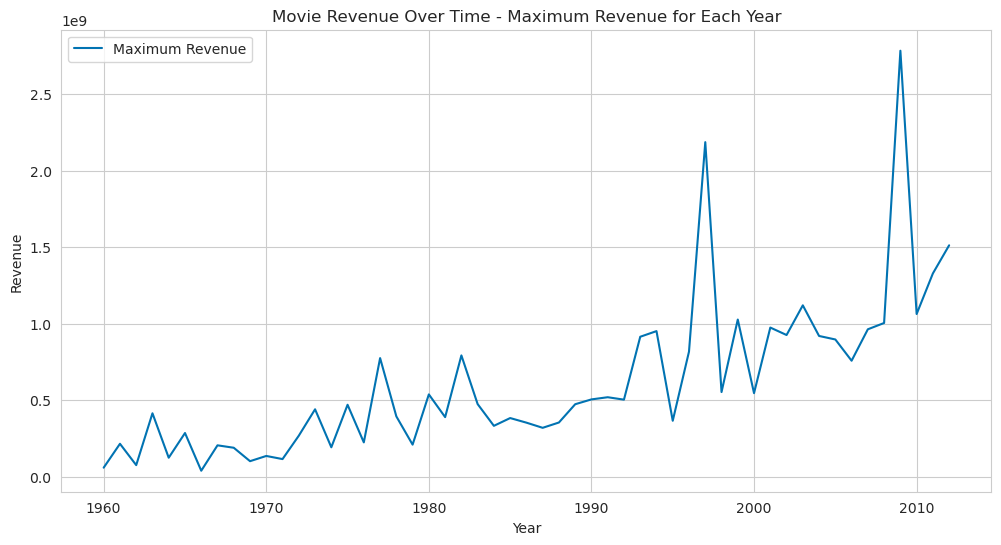

In [36]:
# plot the maximum revenue for each year
max_revenue = movies.groupby(pd.to_datetime(movies["year"]))[["revenue"]].max()

plt.figure(figsize=(12, 6))
plt.plot(max_revenue.index, max_revenue["revenue"], label="Maximum Revenue")
plt.title("Movie Revenue Over Time - Maximum Revenue for Each Year")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.legend()
plt.show()

As we can see, the maximum revenue per year is increasing over time. To accurately compare movie revenues over time, we need to account for inflation. Without this adjustment, comparing movies from different eras becomes misleading. Older movies, which might have been very successful, will seem less profitable due to the lower ticket prices at their time.

The Consumer Price Index is calculated by measuring the price in one period for a fixed basket of consumer goods and services compared to previous periods.

- **Formula**: 
  $$ \text{Adjusted Value} = \left( \frac{\text{Current Value}}{\text{CPI in Current Year}} \right) \times \text{CPI Base Year} $$

- `Current Value`: The original revenue or budget of the movie.
- `CPI in Current Year`: The Consumer Price Index in the year the movie was released.
- `CPI Base Year`: The Consumer Price Index in the base year (2012).


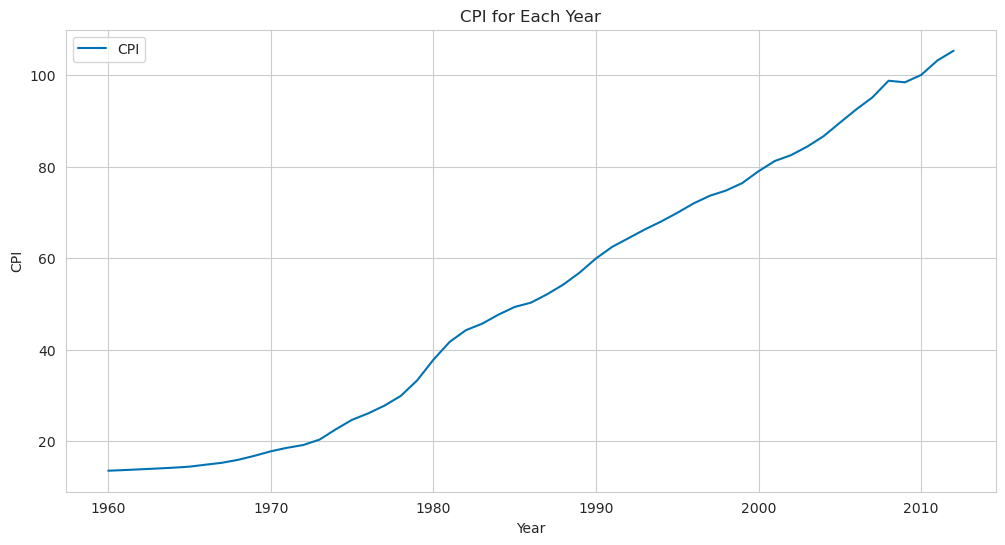

In [37]:
# plot the cpi for each year

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(us_cpi["year"]), us_cpi["cpi"], label="CPI")
plt.title("CPI for Each Year")
plt.xlabel("Year")
plt.ylabel("CPI")
plt.legend()
plt.show()

The graph displays the Consumer Price Index (CPI) for each year, showing an upward trend from 1960 through until 2012.

We'll add two new columns to the dataset, one for the revenue adjusted for inflation and one for the budget adjusted for inflation.

In [38]:
# as our base year we choose 2012
cpi_base_year = us_cpi[us_cpi["year"] == "2012"]["cpi"].values[0]

# merge the movies dataset with the us_inflation dataset on the year column
movies = pd.merge(movies, us_cpi, on="year", how="left")

# calculate adjusted revenue and budget according to the formula
movies["revenue_adjusted"] = (movies["revenue"] / movies["cpi"]) * cpi_base_year
movies["budget_adjusted"] = (movies["budget"] / movies["cpi"]) * cpi_base_year

- When adjusted for inflation, how does the gross revenue of older movies compare to recent modern movies?

We'll plot the original revenue and the inflation-adjusted revenue over time, in order to see the difference.

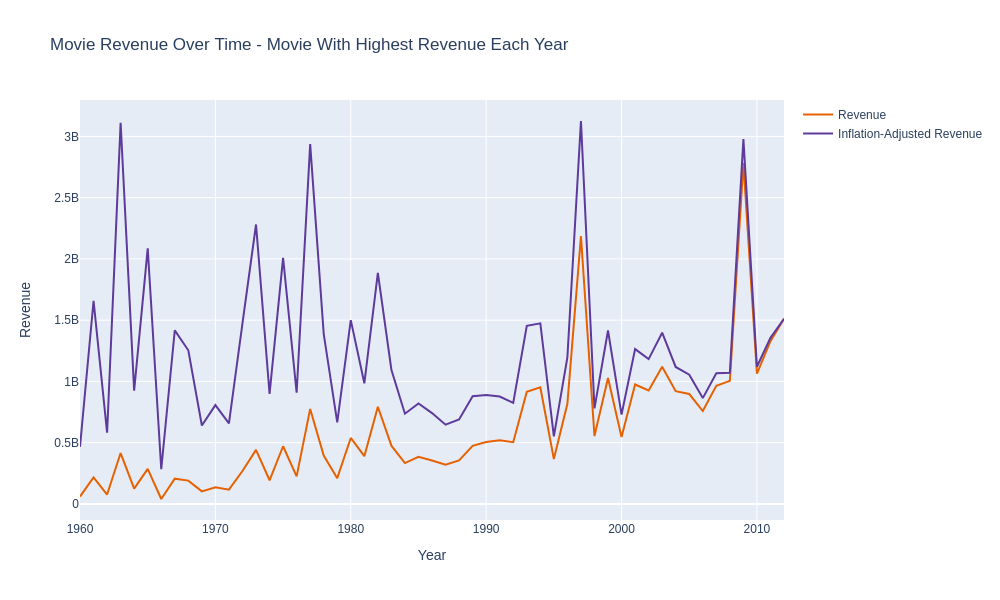

In [39]:
annual_revenue = movies.groupby(pd.to_datetime(movies["year"]))[
    ["revenue", "revenue_adjusted"]
].max()

# create traces
trace1 = go.Scatter(
    x=annual_revenue.index,
    y=annual_revenue["revenue"],
    mode="lines",
    name="Revenue",
    line=dict(color="#E66100"),
)

trace2 = go.Scatter(
    x=annual_revenue.index,
    y=annual_revenue["revenue_adjusted"],
    mode="lines",
    name="Inflation-Adjusted Revenue",
    line=dict(color="#5D3A9B"),
)

layout = go.Layout(
    title="Movie Revenue Over Time - Movie With Highest Revenue Each Year",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Revenue"),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.write_html("plots/revenue_over_time.html")

fig.update_layout(
    width=1000, 
    height=600  
)
pio.show(fig, renderer='png')


From the plot we can see the revenues of the highest-grossing movie of each year with their inflation-adjusted equivalents. 
As we expected,  the inflation-adjusted revenues are higher than the reported revenues as the value of money decreases over time due to inflation. We can also see that the impact of inflation is more pronounced in earlier decades, as seen by the greater distance between the two lines.

After adjusting the revenue for inflation, the peaks in the revenue trends become more pronounced. We can see that some older movies actually have higher inflation-adjusted revenues than newer ones, which wouldn't be apparent if we only looked at nominal revenues.

In [40]:
top_movies = movies.sort_values(by=["revenue_adjusted"], ascending=False).head(5)
top_movies = top_movies[["title", "year", "revenue", "revenue_adjusted"]]
top_movies

,title,year,revenue,revenue_adjusted
1990,Titanic,1997,2.185372e+09,3.125832e+09
637,Love with the Proper Stranger,1963,4.150049e+08,3.111268e+09
2132,Avatar,2009,2.782275e+09,2.977544e+09
7103,Star Wars Episode IV: A New Hope,1977,7.753980e+08,2.937330e+09
2122,The Exorcist,1973,4.410710e+08,2.280793e+09


The movie with the highest nominal revenue is Avatar from 2009, with a revenue of approximately \\$ 2.782 billion. However, when we adjust for inflation, Titanic from 1997 shows a greater revenue than Avatar - an adjusted revenue of approximately \\$ 3.126 billion, compared to Avatar's adjusted revenue of about \\$ 2.978 billion.

Now we want to see if 'older' movies have a higher revenue than 'newer' movies. We define 'older' movies as movies that were released before 2000 and 'newer' movies as movies that were released after 2000.

In [41]:
old_movies_revenues = movies[movies["year"].astype(int) < 2000]["revenue_adjusted"]
new_movies_revenues = movies[movies["year"].astype(int) >= 2000]["revenue_adjusted"]

print("Number of movies before 2000: ", len(old_movies_revenues))
print("Number of movies after 2000: ", len(new_movies_revenues))

Number of movies before 2000:  3551
Number of movies after 2000:  3641


In order to determine this, we first need to check if the data is normally distributed in order to choose the right test. We can do this by plotting a histogram and a Q-Q plot.

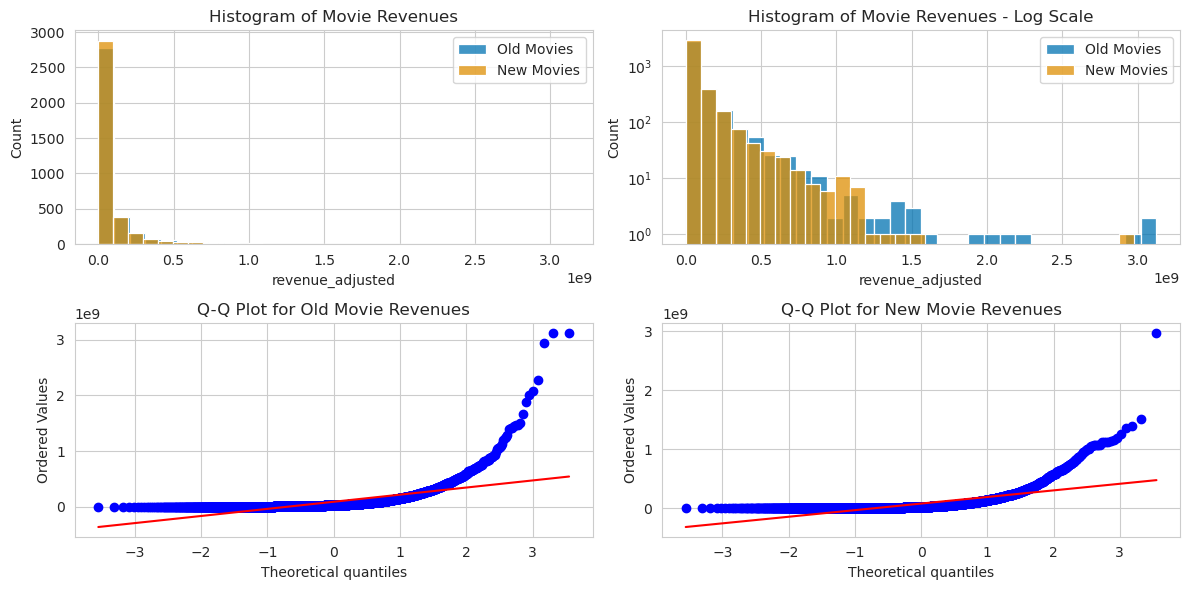

In [42]:
plt.figure(figsize=(12, 6))

# histogram
plt.subplot(2, 2, 1)
sns.histplot(old_movies_revenues, bins=30, kde=False, label="Old Movies")
sns.histplot(new_movies_revenues, bins=30, kde=False, label="New Movies")
plt.legend()
plt.title("Histogram of Movie Revenues")

# histogram with log scale
plt.subplot(2, 2, 2)
sns.histplot(old_movies_revenues, bins=30, kde=False, label="Old Movies")
sns.histplot(new_movies_revenues, bins=30, kde=False, label="New Movies")
plt.yscale("log")
plt.legend()
plt.title("Histogram of Movie Revenues - Log Scale")

# Q-Q plot for old movies
plt.subplot(2, 2, 3)
stats.probplot(old_movies_revenues, dist="norm", plot=plt)
plt.title("Q-Q Plot for Old Movie Revenues")

# Q-Q plot for new movies
plt.subplot(2, 2, 4)
stats.probplot(new_movies_revenues, dist="norm", plot=plt)
plt.title("Q-Q Plot for New Movie Revenues")

plt.tight_layout()
plt.show()

From the histogram we can see that the distribution of the revenues for both groups is not normal. Additionaly, the Q-Q plots which are used to assess how closely the data follows a normal distribution, show that the data is not normally distributed. 

Because of this, we will use the Mann-Whitney U test. The null hypothesis is that there is no significant difference in median revenues between older and newer movies, while the alternative hypothesis is that there is a significant difference. In this analysis, we will use a 0.05 level of significance. This means that if our p-value is less than 0.05, we will reject the null hypothesis and accept the alternative hypothesis.

In [43]:
median_revenue_old = old_movies_revenues.median()
median_revenue_new = new_movies_revenues.median()

# perform a Mann-Whitney U Test to see if there is a difference between the median revenues of old movies and new movies
res = mannwhitneyu(old_movies_revenues.values, new_movies_revenues.values)
print("Mann-Whitney U test: \n statistic =", res.statistic, "\n p =", res.pvalue)
print(
    "Median revenue for older movies =",
    "{:.3f}".format(median_revenue_old),
    "\nMedian revenue for newer movies =",
    "{:.3f}".format(median_revenue_new),
)

Mann-Whitney U test: 
 statistic = 7220205.0 
 p = 9.230451138874896e-18
Median revenue for older movies = 28111512.427 
Median revenue for newer movies = 19323866.660


The p-value is less than 0.05, indicating that there is a statistically significant difference between the median revenues of older movies (released before the year 2000) and newer movies (released in or after the year 2000). Given the median revenues, we can conclude that older movies have a significantly higher median revenue than newer movies when adjusted for inflation.

### Is there a notable trend in the budget of movies over the years when considering inflation?

We can plot the original budget and the inflation-adjusted budget over time, in order to see the difference.

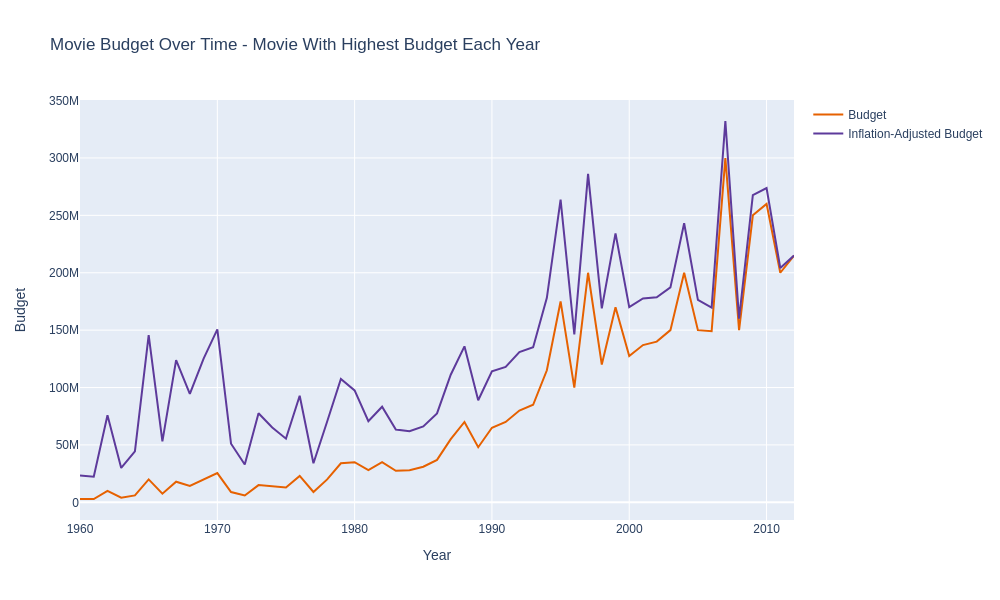

In [44]:
# group by year and get the movie with max budget and revenue_inflation
annual_budget = movies.groupby(pd.to_datetime(movies["year"]))[
    ["budget", "budget_adjusted"]
].max()

# create traces
trace1 = go.Scatter(
    x=annual_budget.index,
    y=annual_budget["budget"],
    mode="lines",
    name="Budget",
    line=dict(color="#E66100"),
)

trace2 = go.Scatter(
    x=annual_budget.index,
    y=annual_budget["budget_adjusted"],
    mode="lines",
    name="Inflation-Adjusted Budget",
    line=dict(color="#5D3A9B"),
)

layout = go.Layout(
    title="Movie Budget Over Time - Movie With Highest Budget Each Year",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Budget"),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.write_html("plots/budget_over_time.html")

fig.update_layout(
    width=1000, 
    height=600  
)
pio.show(fig, renderer='png')

Again as expected, the inflation-adjusted budgets are consistently higher than the nominal budgets, illustrating the impact of inflation over time. Both the nominal and inflation-adjusted budget lines show an overall upward trend, indicating that the budgets for the high-budget movies per year have been increasing over the decades.

We'll do a Pearson correlation between the inflation-adjusted budget and year to see if there is actually a linear correlation between the two.

In [45]:
movies_with_budget = movies.dropna(subset=["budget_adjusted"])
pearson_corr_coefficient, p_value = stats.pearsonr(
    movies_with_budget["year"].astype(float),
    movies_with_budget["budget_adjusted"],
)

print(f"Pearson's correlation coefficient: {pearson_corr_coefficient}")
print(f"P-value: {p_value}")

Pearson's correlation coefficient: 0.13043034760366937
P-value: 4.633704347063562e-08


The weak positive correlation coefficient and the low p-value suggest a statistically significant, yet not strong, linear relationship between the movie's release year and its inflation-adjusted budget.

The overall upward trend in both nominal and inflation-adjusted movie budgets could be related to broader economic growth, such as increases in GDP. As the economy grows, the movie industry seems to grow with it. We will explore this in the following section.

## Q2: Global Economic Growth and its Influence on the Movie Industry 

### What is the relationship between global economic indicators (like GDP) and a movie's gross revenue? 

Gross Domestic Product (GDP) is the total cash value of everything produced within the nation - a true heartbeat of the country's economy. It's a great economic growth indicator because it tells us how healthy the economy is. When it comes to movies making bucks, GDP is a big deal. A high GDP means people have more money to spend on tickets and popcorn. This way we can see the impact that economic growth has on movie revenue, by comparing how well the two move together.

We kick off, with a simple graph with relative yearly values of the world's GDP and mean movie revenue, spanning from 1960 to 2012. Our eyes are the primary sense that allows us to delve into the cinematic experience - and they can also help us quickly assess the relation between the two.

In [46]:
movies["country"] = movies["countries"].apply(lambda x: x.split(":")[-1].strip("}").replace('"', '').strip())
movies["country"].replace("{", "Unknown", inplace=True)

gdp_data_preprocessed = gdp_data.copy()
gdp_data_preprocessed["Country Name"].replace("United States", "United States of America", inplace=True)
gdp_data_preprocessed = gdp_data_preprocessed.set_index("Country Name").loc[:, gdp_data.columns[4:-1]]
gdp_data_preprocessed_transposed = gdp_data_preprocessed.T
gdp_data_preprocessed_transposed.index = gdp_data_preprocessed_transposed.index.astype(int)

mean_movie_revenue_by_year = movies.groupby("year")["revenue"].mean()

world_gdp = gdp_data_preprocessed_transposed["World"].loc[:2012]

relative_world_gdp = world_gdp / world_gdp.iloc[0]
relative_mean_movie_revenue_by_year = mean_movie_revenue_by_year / mean_movie_revenue_by_year.iloc[0]

spearman_world_gdp_mean_movie_revenue = stats.spearmanr(relative_world_gdp, relative_mean_movie_revenue_by_year)
pearson_world_gdp_mean_movie_revenue = stats.pearsonr(relative_world_gdp, relative_mean_movie_revenue_by_year)

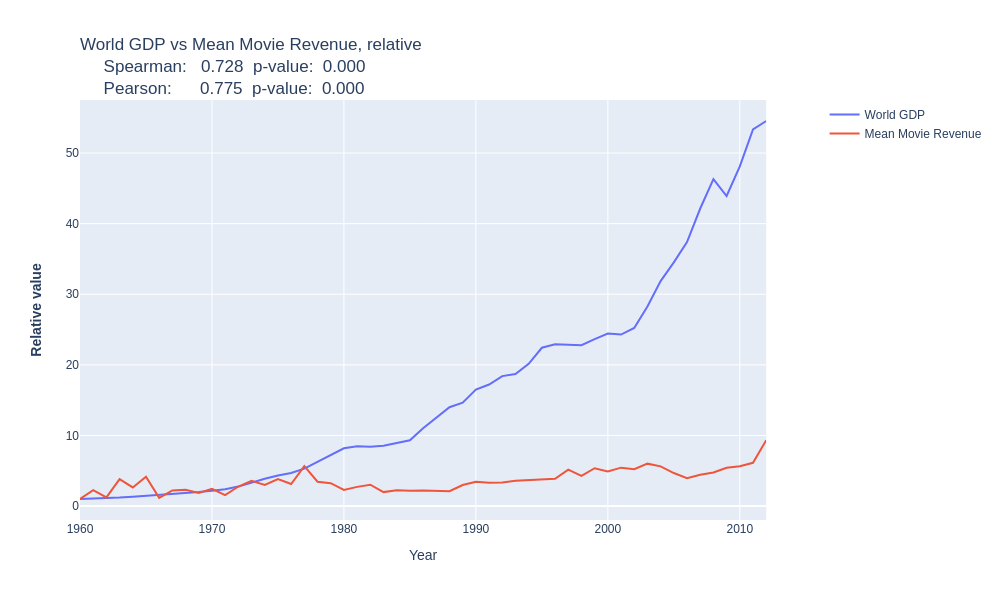

In [47]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=relative_world_gdp.index, y=relative_world_gdp, name="World GDP"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=relative_mean_movie_revenue_by_year.index, y=relative_mean_movie_revenue_by_year, name="Mean Movie Revenue"),
    secondary_y=False,
)

fig.update_layout(
    # title_text=f"World GDP vs Mean Movie Revenue, relative<br>Spearman: {spearman[0]:.3f}, p-value: {spearman[1]:.3f}<br>Pearson: {pearson[0]:.3f}, p-value: {pearson[1]:.3f}",
    title_text = f"""
    World GDP vs Mean Movie Revenue, relative<br>
    Spearman: {spearman_world_gdp_mean_movie_revenue[0]:>7.3f}  p-value: {spearman_world_gdp_mean_movie_revenue[1]:>6.3f}<br>
    Pearson:    {pearson_world_gdp_mean_movie_revenue[0]:>7.3f}  p-value: {pearson_world_gdp_mean_movie_revenue[1]:>6.3f}
    """,
    title_x=0.08,
)

fig.update_xaxes(title_text="Year")

fig.update_yaxes(title_text="<b>GDP</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Relative value</b>", secondary_y=False)

fig.write_html("plots/world_gdp_vs_mean_movie_revenue.html")

fig.update_layout(
    width=1000, 
    height=600  
)
pio.show(fig, renderer='png')

At first glance, this may look like a catastrophic flop. Something that would make a movie studio completely abandon the idea... But wait! Look at the correlations! Both Spearman and Pearson coefficients indicate a high level of correlation between the two time series and are backed, by p-values way smaller than 0.05. We can confidently say that even if the two are not moving tightly together, they still show similar behavior and like to either grow or shrink at the same time.

Some John Doe can now wonder: "Hmm, okay... But nothing in life is this simple. There have to be some deviations from this relation. I can't believe that some random third-world country's GDP correlates with movie revenue the same as the cradle of the movie industry that the USA is". And it is a completely logical argument. We would expect that the correlation between GDP and movie revenue of rich countries will be bigger than countries that are still in the early development phase - they just have more money to spend on the entertainment industry.

To try and unravel whether this common sense logic is true, we can move from the whole screen to separate pixels - zoom in to how the GDP of each of the countries correlates with movie revenue. 

In [48]:
gdp_revenue_correlation = pd.DataFrame(columns=["pearson", "spearman", "pearson_p", "spearman_p"], index=gdp_data_preprocessed.index)

for country in gdp_data_preprocessed.index:
    gdp_isna = gdp_data_preprocessed_transposed.loc[1960:2012, country].isna()
    mean_movie_revenue_by_year_isna = mean_movie_revenue_by_year.isna()
    temp_gdp = gdp_data_preprocessed_transposed.loc[1960:2012, country][~gdp_isna.values & ~mean_movie_revenue_by_year_isna.values]
    temp_mean_revenue = mean_movie_revenue_by_year[~gdp_isna.values & ~mean_movie_revenue_by_year_isna.values]

    if len(temp_gdp) < 2:
        gdp_revenue_correlation.loc[country] = [np.nan, np.nan, np.nan, np.nan]
        print(f"Skipping {country} due to insufficient data")
        continue
    spearman = stats.spearmanr(temp_gdp, temp_mean_revenue)
    pearson = stats.pearsonr(temp_gdp, temp_mean_revenue)
    if spearman[1] > 0.05 and pearson[1] > 0.05:
        gdp_revenue_correlation.loc[country] = [np.nan, np.nan, pearson[1], spearman[1]]
    elif spearman[1] > 0.05:
        gdp_revenue_correlation.loc[country] = [pearson[0], np.nan, pearson[1], spearman[1]]
    elif pearson[1] > 0.05:
        gdp_revenue_correlation.loc[country] = [np.nan, spearman[0], pearson[1], spearman[1]]
    else:
        gdp_revenue_correlation.loc[country] = [pearson[0], spearman[0], pearson[1], spearman[1]]

gdp_revenue_correlation = gdp_revenue_correlation.astype(float)
gdp_revenue_correlation = pd.merge(gdp_revenue_correlation, gdp_data[["Country Name", "Country Code"]], left_index=True, right_on="Country Name", how="left").set_index("Country Name")
gdp_revenue_correlation.loc["United States of America", "Country Code"] = "USA"
gdp_revenue_correlation.reset_index(inplace=True)

gdp_revenue_correlation

Skipping Gibraltar due to insufficient data
Skipping Not classified due to insufficient data
Skipping St. Martin (French part) due to insufficient data
Skipping Korea, Dem. People's Rep. due to insufficient data
Skipping British Virgin Islands due to insufficient data


,Country Name,pearson,spearman,pearson_p,spearman_p,Country Code
0,Aruba,0.770988,0.814408,2.524109e-06,2.350332e-07,ABW
1,Africa Eastern and Southern,0.740248,0.717949,2.382191e-10,1.440982e-09,AFE
2,Afghanistan,0.782243,0.775735,7.585391e-08,1.139899e-07,AFG
3,Africa Western and Central,0.696825,0.645783,6.816211e-09,1.774209e-07,AFW
4,Angola,0.677240,0.621710,1.501282e-05,1.124894e-04,AGO
...,...,...,...,...,...,...
261,Kosovo,NaN,NaN,2.111716e-01,1.040880e-01,XKX
262,"Yemen, Rep.",0.685074,0.747036,3.099252e-04,4.213902e-05,YEM
263,South Africa,0.741815,0.709724,2.084800e-10,2.682156e-09,ZAF
264,Zambia,0.686722,0.695049,1.368704e-08,7.720406e-09,ZMB


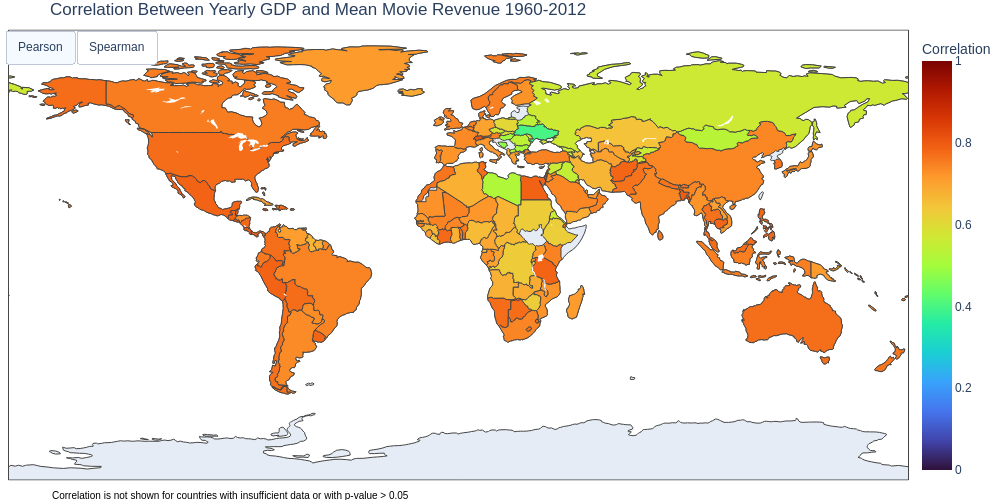

In [49]:
fig = px.choropleth(gdp_revenue_correlation, locations="Country Code",
                    color="pearson", # lifeExp is a column of gapminder
                    hover_name="Country Name", # column to add to hover information
                    hover_data=["pearson", "spearman", "pearson_p", "spearman_p"],
                    color_continuous_scale=px.colors.sequential.Turbo, range_color=(0, 1))
fig.update_layout(paper_bgcolor='rgb(255, 255, 255)',
                  margin=dict(t=30, r=0,  l=0, b=50), dragmode=False)
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Correlation",
        x=1,
    ),
    title={
    'text': "Correlation Between Yearly GDP and Mean Movie Revenue 1960-2012",
    }
)

updatemenu = [
    {
        'type': 'buttons',
        'direction': 'right',
        'x': 0,
        'xanchor': 'left',
        'y': 1,
        'yanchor': 'top',
        'buttons': [
            {
                'method': 'restyle',
                'label': 'Pearson',
                'args': [{'z': [gdp_revenue_correlation['pearson']],
                          'colorbar': {'title': 'Pearson Correlation'}}, [0]],
            },
            {
                'method': 'restyle',
                'label': 'Spearman',
                'args': [{'z': [gdp_revenue_correlation['spearman']],
                          'colorbar': {'title': 'Spearman Correlation'}}, [0]],
            }
        ],
        'showactive': True,
    }
]

fig.update_layout(
    updatemenus=updatemenu,
    paper_bgcolor='rgb(255, 255, 255)',
    margin=dict(t=30, r=0, l=5, b=20),
    dragmode=False,

)

fig.add_annotation(
    xref='paper', yref='paper',
    x=0.05, y=-0.05,
    text="Correlation is not shown for countries with insufficient data or with p-value > 0.05",
    showarrow=False,
    align="center",
    font=dict(size=10, color="black")
)


fig.write_html("plots/gdp_revenue_correlation.html")

fig.update_layout(
    width=1000, 
    height=500  
)
pio.show(fig, renderer='png')

Now that is a very interesting picture. We see that there certainly are divergences from how the worlds GDP correlates with movie revenue. Whats even more interesting - correlation is still quite high for developing countries in Africa, but the whole post-soviet region glows green. Is this a cold war stigma? Between 1960 and 1989, when the Iron Curtain was still casting shadow, most of the western movies were either completely unavaible in this part of the world or their screenings were delayed significantly (*Star Wars* made it to Hungarian cinemas almost two years after it's official release). Let's take a closer look.

In [50]:
def same_index_no_nans(x1, x2):
    shared_idx = x1.index.intersection(x2.index)
    x1 = x1[shared_idx]
    x2 = x2[shared_idx]
    x1_isna = x1.isna()
    x2_isna = x2.isna()
    x1 = x1[~x1_isna.values & ~x2_isna.values]
    x2 = x2[~x1_isna.values & ~x2_isna.values]
    return x1, x2

In [51]:
ussr_countries = ["RUS", "UKR", "BLR", "MDA", "EST", "LVA", "LTU", "GEO", "ARM", "AZE", "KAZ", "UZB", "TKM", "KGZ", "TJK"]
eastern_bloc_countries = ["POL", "DEU", "CZE", "SVK", "HUN", "ROU", "BGR", "ALB"]
all_ussr_related = [
    "ARM", "AZE", "BLR", "EST", "GEO", "KAZ", "KGZ", "LVA", "LTU", "MDA", 
    "RUS", "TJK", "TKM", "UKR", "UZB", "AFG", "ALB", "AGO", "BEN", "BGR", 
    "CHN", "COD", "COG", "CUB", "CZE", "SVK", "DEU", "ETH", "GRD", "HUN", 
    "KHM", "LAO", "MNG", "MOZ", "PRK", "POL", "ROU", "SYC", "SOM", "YEM", 
    "VNM", "BIH", "HRV", "MKD", "MNE", "SRB", "SVN", "XKX"
]

gdp_data_ussr_related = gdp_data[gdp_data["Country Code"].isin(all_ussr_related)].set_index("Country Name").loc[:, gdp_data.columns[4:-1]].T
gdp_data_ussr_related.index = gdp_data_ussr_related.index.astype(int)

gdp_revenue_correlation

,Country Name,pearson,spearman,pearson_p,spearman_p,Country Code
0,Aruba,0.770988,0.814408,2.524109e-06,2.350332e-07,ABW
1,Africa Eastern and Southern,0.740248,0.717949,2.382191e-10,1.440982e-09,AFE
2,Afghanistan,0.782243,0.775735,7.585391e-08,1.139899e-07,AFG
3,Africa Western and Central,0.696825,0.645783,6.816211e-09,1.774209e-07,AFW
4,Angola,0.677240,0.621710,1.501282e-05,1.124894e-04,AGO
...,...,...,...,...,...,...
261,Kosovo,NaN,NaN,2.111716e-01,1.040880e-01,XKX
262,"Yemen, Rep.",0.685074,0.747036,3.099252e-04,4.213902e-05,YEM
263,South Africa,0.741815,0.709724,2.084800e-10,2.682156e-09,ZAF
264,Zambia,0.686722,0.695049,1.368704e-08,7.720406e-09,ZMB


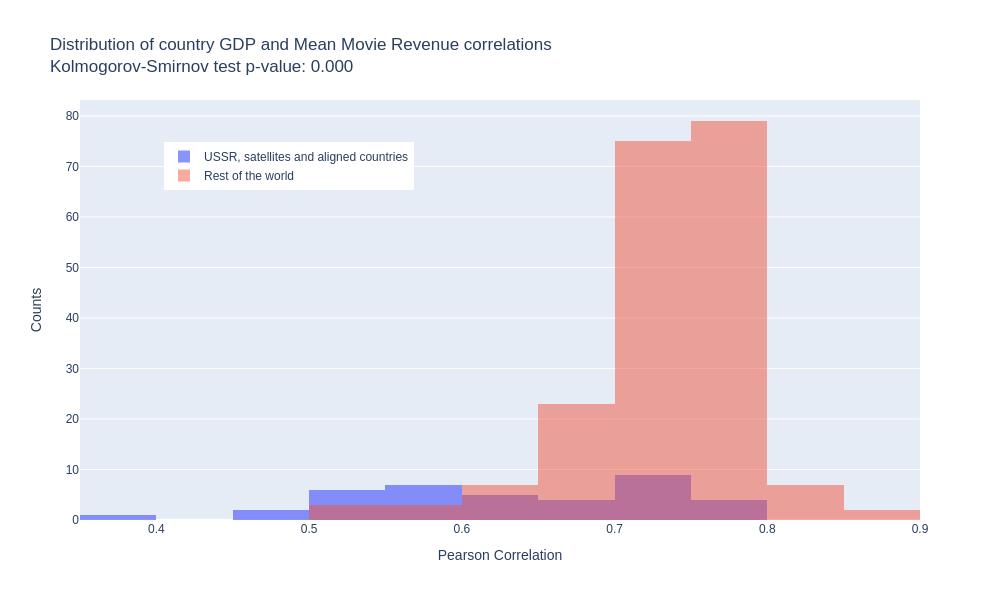

In [52]:
gdp_revenue_correlation_ussr_related = gdp_revenue_correlation.set_index("Country Code").loc[all_ussr_related, :].reset_index()
gdp_revenue_correlation_no_ussr = gdp_revenue_correlation[~gdp_revenue_correlation["Country Code"].isin(all_ussr_related)]

pearson_ussr = gdp_revenue_correlation_ussr_related["pearson"]
pearson_no_ussr = gdp_revenue_correlation_no_ussr["pearson"]

ks_statistic, p_value = ks_2samp(pearson_ussr, pearson_no_ussr)

hist_ussr = go.Histogram(
    x=pearson_ussr,
    name="USSR, satellites and aligned countries",
    opacity=0.75,
    nbinsx=15 
)

hist_no_ussr = go.Histogram(
    x=pearson_no_ussr,
    name="Rest of the world",
    opacity=0.5,
    nbinsx=15
)

layout = go.Layout(
    title=f"Distribution of country GDP and Mean Movie Revenue correlations<br>Kolmogorov-Smirnov test p-value: {p_value:.3f}",
    barmode='overlay',
    xaxis_title="Pearson Correlation",
    yaxis_title="Counts",
    legend=dict(x=0.1, y=0.9)
)

fig = go.Figure(data=[hist_ussr, hist_no_ussr], layout=layout)

fig.write_html("plots/gdp_revenue_correlation_ussr.html")

fig.update_layout(
    width=1000, 
    height=600  
)
pio.show(fig, renderer='png')

After separating the correlations of the USSR, its satellite and aligned countries, and the rest of the world, we can see that the distributions are different. We also confirmed it, by the p-value of (oh, the irony) Kolmogorov-Smirnov test smaller than 0.05. It really looks like there are regional differences in how the GDP and movie revenue are related, and we have strong reasons to believe that it is a consequence of the soviet rule - thankfully, one of the most harmless ones.

---

## Q3: Determinants of a Movie's Financial Success 
### How do factors like budget, runtime, and movie ratings impact the movie's revenue or profitability?


People find it easy to distinguish between a low-budget and a high-budget movie. However, this does not imply that a movie with a high budget will be successful, as many factors contribute to a movie's financial success. In this section, we will briefly explore the relationship between a movie's budget and its revenue, as well as introduce the concept of movie profit and the rate of return on investment.

### Budget and Revenue

The first concept we will try to explore is whether budget and revenue are correlated. We expect that if more money is invested in the movie's production, it will generate more revenue.

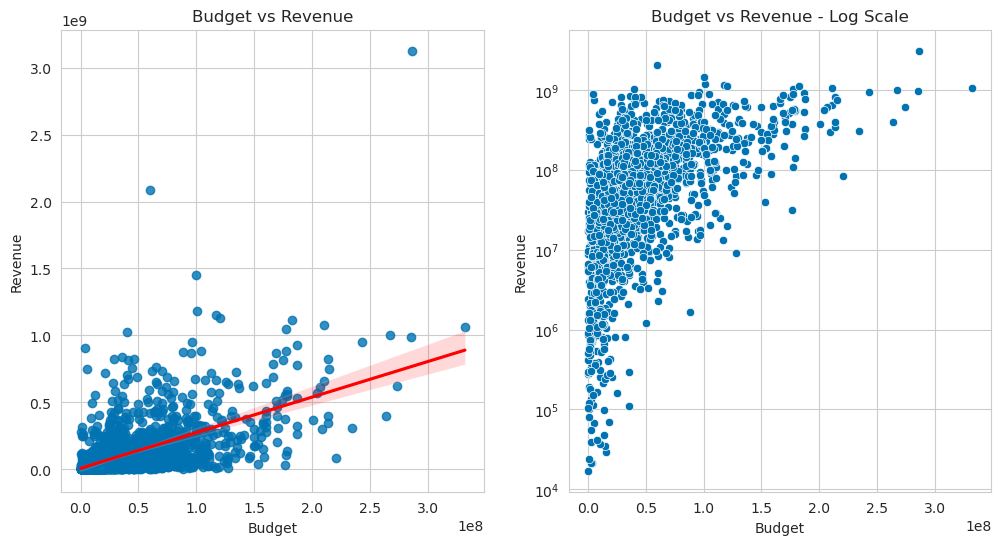

In [65]:
# plotting budget and revenue with a linear y scale (left) and log y scale (right)
# linear regression line is also shown on the left plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(
    ax=axes[0],
    data=movies_with_budget,
    x="budget_adjusted",
    y="revenue_adjusted",
    line_kws={"color": "red"},
)
sns.scatterplot(
    ax=axes[1],
    data=movies_with_budget,
    x="budget_adjusted",
    y="revenue_adjusted",
)
axes[1].set_yscale("log")
axes[0].set_title("Budget vs Revenue")
axes[1].set_title("Budget vs Revenue - Log Scale")
axes[0].set_xlabel("Budget")
axes[0].set_ylabel("Revenue")
axes[1].set_xlabel("Budget")
axes[1].set_ylabel("Revenue")
plt.show()

On a first glance, by observing the blue dots on the left linear-axis plot, it cannot be clearly shown whether putting more money into the movie will generate a higher return. It seems as if most of the movies are lower and upper bounded by some value for budget and revenue, making the scatter plot dense. In order to possibly reveal the true relationship between the two variables we do the following:

1. Plotting a regression line reveals a positive relationship between budget and revenue. That is, the more budget is given for a movie, the more revenue it's expected to achieve.
2. This is also more evidently visible by displaying the revenue on a logarithmic y-scale (right plot) where the higher the budget is, the higher the lower bound is for the corresponding revenue.

Additionally, we perform a Pearson and Spearman statistics test in order to certainly quantify the linear relationship between budget and revenue.

In [66]:
# check correlation between budget and revenue with pearson and spearman
print(
    "Pearson Correlation: ",
    stats.pearsonr(
        movies_with_budget["budget_adjusted"],
        movies_with_budget["revenue_adjusted"],
    ),
)
print(
    "Spearman Correlation: ",
    stats.spearmanr(
        movies_with_budget["budget_adjusted"],
        movies_with_budget["revenue_adjusted"],
    ),
)

Pearson Correlation:  PearsonRResult(statistic=0.5706510359479668, pvalue=3.744954740487031e-151)
Spearman Correlation:  SignificanceResult(statistic=0.6010321314073527, pvalue=1.1190326937062103e-171)


It is now clearly evident from the p-value smaller than 0.05, that budget and revenue are significantly positiviely correlated with a coefficient of ~ 0.6. We can therefore argue that a movie's revenue value is unlikely to have occured by random chance alone, and is likely tied to the budget.

### Profit

Most of the time, the real financial performance of a movie is measured by its profit. That is, the difference between revenue and budget:


$$ \text{profit = revenue - budget} $$

We are aware that the movie's profit is dependent on other factors such as social media, merchandise sales and streaming rights, which can also influence its overall financial success. However, since we don't have the data for all of that, we will calculate the profit as the difference between revenue and budget.

This implies that a certain movie could either make profit (if revenue > budget), or loss (if revenue < budget). We start by discovering the top 5 movies that fall into each category and capture some interesting observations.



Which 5 movies made the most and the least profit? Could it happen that some movies even made a loss?

In [67]:
movies["profit"] = movies["revenue_adjusted"] - movies["budget_adjusted"]
display(
    movies.sort_values(by=["profit"], ascending=False).head(5)[
        ["title", "year", "profit", "imdb_rating"]
    ]
)
print(
    "Number of movies that made profit: ",
    len(movies[movies["profit"] > 0]),
)
display(
    movies.sort_values(by=["profit"], ascending=True).head(5)[
        ["title", "year", "profit", "imdb_rating"]
    ]
)
print("Number of movies that made loss: ", len(movies[movies["profit"] < 0]))

,title,year,profit,imdb_rating
1990,Titanic,1997,2.839764e+09,7.9
3876,The Sound of Music,1965,2.025826e+09,8.1
5540,Jurassic Park,1993,1.353630e+09,8.2
749,The Lord of the Rings: The Two Towers,2002,1.081178e+09,8.8
1185,Finding Nemo,2003,1.032297e+09,8.2


Number of movies that made profit:  1209


,title,year,profit,imdb_rating
5293,The Alamo,2004,-1.448673e+08,6.0
3452,The 13th Warrior,1999,-1.354905e+08,6.6
4335,The Adventures of Pluto Nash,2002,-1.185783e+08,3.9
6693,Mars Needs Moms,2011,-1.133044e+08,5.4
2615,Town & Country,2001,-1.032495e+08,4.5


Number of movies that made loss:  527


Almost everyone has heard of the top 5 highest grossing movies (available in our dataset). These are the movies that gained an enormous and exceptional revenue compared to its budget and to the revenue gained by the other movies. Contradictingly, the movies that made a loss are less known and are significantly underperforming in terms of profit when compared to other movies.

It is also interesting to see that the average IMDB rating of the top 5 movies is 8.36 and for the worst 5 movies is 5.28. However, this is also an analysis topic to dig into deeper and these ratings are shown only for illustrative purposes for now.

Furthermore, it is left as an open question to discuss and claim why a certain movie might make a loss. We had shown before that budget and revenue are moderatily positively related, but we cannot predict a movie's revenue solely based on the given budget. This raises the potential issue of having further confounders (in addition to the budget) affecting the movie's revenue, and therefore its profit. However, this is intuitevely clear to us as movie watchers as we know many factors, such as its genre or actors, could contribute to a movie's success. Later on in the analysis, we try to detangle possible confounders and clearly detect all variables that affect the movie's profit.

<b> Fun fact: </b> The movies that lost money are called <u>box office bombs</u>!

How has the trend of profit changed over time? Should we expect to see more movies with higher profit in the future?

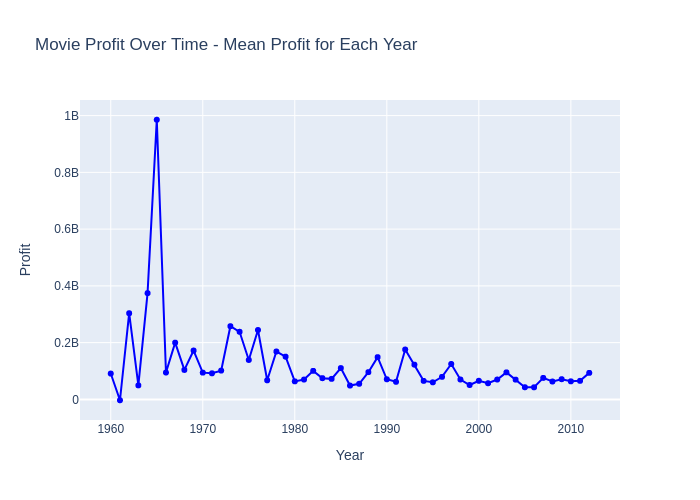

In [71]:
# plot the profit of movies over time
# Scatter plot for mean profit over time

mean_profit_per_year = movies.groupby(pd.to_datetime(movies["year"]))["profit"].mean()

# Scatter plot for mean profit over time
scatter_trace = go.Scatter(
    x=mean_profit_per_year.index,
    y=mean_profit_per_year,
    mode="lines+markers",
    name="Mean Profit",
    marker=dict(color="blue"),
)

# Set layout properties
layout = go.Layout(
    title="Movie Profit Over Time - Mean Profit for Each Year",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Profit", type="linear"),
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

fig.write_html("plots/q3_profit_over_time.html")

pio.show(fig, renderer='png')

Looking at the plot we can see that the mean profit of movies over time is somewhat similar and is upper/lower bounded, with some years performing better or worse than other ones. However, we can see that the mean profit of movies is slightly decreasing over time and varies less. These are the years with highest and lowest mean profit:

In [72]:
# create a list storing the profit for each year
profit_per_year = []
for year in movies["year"].unique():
    profit_per_year.append(movies[movies["year"] == year]["profit"].mean())

# year with the highest and lowest profit
print(
    "Year with highest profit: ",
    movies["year"].unique()[np.argmax(profit_per_year)],
)
print(
    "Year with lowest profit: ",
    movies["year"].unique()[np.argmin(profit_per_year)],
)

Year with highest profit:  1965
Year with lowest profit:  1961


In order to precisely determine the impact of the year on profit, we perform a one-way ANOVA test to check if the mean profit of movies is the same for all years ($H_0$). This would show whether there exists a significant difference in the mean profit of movies for different years.

In [73]:
print(stats.f_oneway(movies["year"].unique(), profit_per_year))
print(stats.spearmanr(movies["year"].unique(), profit_per_year))

F_onewayResult(statistic=40.90813182701674, pvalue=4.6351722914999435e-09)
SignificanceResult(statistic=-0.4546040961135301, pvalue=0.0006270072495625316)


The p-value from the ANOVA test is smaller than 0.05, meaning that we can reject the null hypothesis and accept the alternative that the means are different for different years. Additionally, with the Spearman correlation test we can see that there is a negative correlation between the year and the profit. This means that the profit decreases over time. However, we cannot clearly separate the factors that influence the decrease in profit for now.

What were the chances of a movie making an outstanding profit in the past?

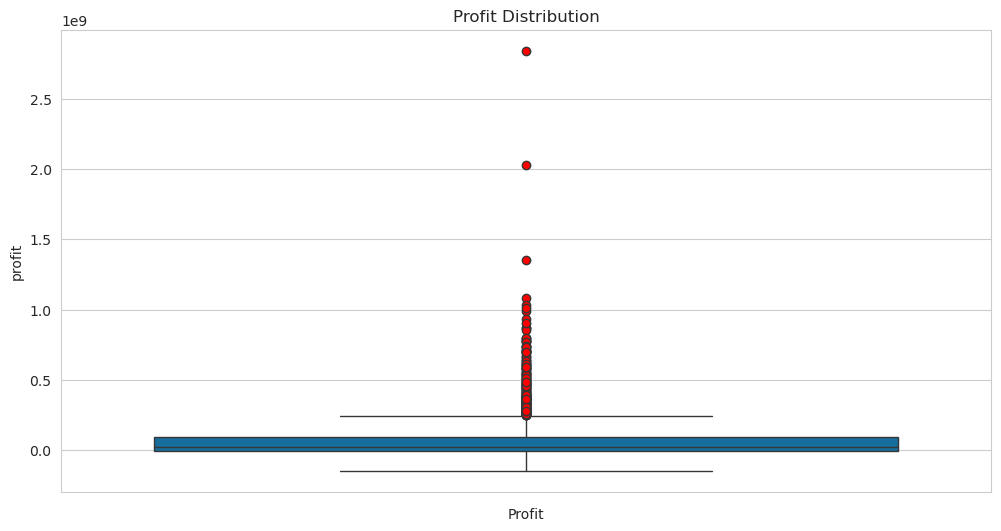

In [80]:
# find movies that made an exceptional profit (outliers)
all_profits = movies[["profit", "budget"]]
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=all_profits["profit"], flierprops=dict(markerfacecolor="r", marker="o")
)
plt.title("Profit Distribution")
plt.xlabel("Profit")
plt.yscale("linear")
plt.show()

In this part, we turn to the movie outliers (red points) and try to characterize them. These are the movies that made an exceptional profit (above 95%) and that significantly stand out from the rest of the movies. What were the chances of a movie being an outlier in the past?

In [81]:
# calculate the number of positive outliers in the boxplot distribution
q1 = all_profits["profit"].quantile(0.25)
q3 = all_profits["profit"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + (1.5 * iqr)
exceptional_profits = all_profits[all_profits["profit"] > upper_bound]
print("Number of movies with an exceptional profit: ", len(exceptional_profits))
# print chances of movie making exceptional profit formatted in %
print(
    "Chances of a movie making exceptional profit in the past: ",
    "{:.2f}".format(len(exceptional_profits) / len(all_profits) * 100),
    "%",
)

Number of movies with an exceptional profit:  171
Chances of a movie making exceptional profit in the past:  2.38 %


We calculated that a movie had 2.38% chance of making a huge profit. We understand that this is a biased comparisson to the real-world scenario in the movie industry, but we assume that the given dataset is almost equally representative of the real movie data and therefore make this comparisson. It is hard to answer whether a future movie also has a similar chance of making an exceptional profit, but we can assume that the chances are lower than in the past, as the profit overall is decreasing over time (as shown previously).

### Return on Investment (ROI)
Another metric for measuring a movie financial success is ROI. ROI is the percentage of the original investment that was gained or lost. It is calculated as follows:
$$ ROI := \left( \frac{revenue - budget}{budget} \right) \times 100 $$
We can claim that ROI is a more representative metric of the success as it is a relative measure of financial success or failure in terms of percentage of the original investment.

Now, we want to analyze movies that had a high return on investment (ROI). These are the movies that had a high return on investment despite having a possibly low budget. Here are some differences in terms of representing profit and ROI: 
1. Scale: 
    - Profit: real monetary amount gained or lost 
    - ROI: percentage of the original investment that was gained or lost 
2. Direction: 
    - Profit: positive or negative financial gain 
    - ROI: positive or negative percentage of the original investment 
3. Interpretation: 
    - Profit: straightforward absolute measure of financial success or failure in terms of dollars 
    - ROI: relative measure of financial success or failure in terms of percentage of the original investment

In [82]:
# calculate ROI for movies with budget > 0
movies["roi"] = (movies["profit"] / movies["budget_adjusted"]) * 100
movies = movies.replace([np.inf, -np.inf], np.nan)

# create a deep copy of movies to prevent modifying the original dataset for later tasks
movies_finance = movies.copy(deep=True)

# remove inf and NaN rows due to division of zero
movies_finance = movies_finance.dropna(subset=["roi"])

# identify top 5 movies with the highest ROI
display(
    movies_finance.sort_values(by=["roi"], ascending=False).head(5)[
        ["title", "year", "roi", "imdb_rating"]
    ]
)

,title,year,roi,imdb_rating
3551,Night of the Living Dead,1968,36742.105263,7.8
4467,Mad Max,1979,24900.000000,6.8
1092,Halloween,1978,23233.333333,7.7
7027,Rocky,1976,22400.000000,8.1
5136,Joe,1970,18125.711321,6.8


We can see these movies are different from the ones that had the highest profit. They have a much lower budget, but a much higher ROI. This means that they had a much higher return on investment, despite having a lower budget, showing that how much you invest in a movie is not the only factor that determines its financial success.

In [83]:
# correlation between profit and roi
print(
    "Pearson Correlation: ",
    stats.pearsonr(movies_finance["profit"], movies_finance["roi"]),
)

Pearson Correlation:  PearsonRResult(statistic=0.2314628170639091, pvalue=1.246601857354523e-22)


Additionally, We can see that there is a positive correlation between profit and ROI, and we find that significant since the p-value is <0.05. This means that the higher the profit, the higher the ROI. However, we cannot conclude that the profit is the only factor that determines the ROI.

### Movie Runtime
In this section we dive deeper into the technical aspects of the movie, namely, its runtime measured in terms of minutes. We want to see if there is a relationship between the runtime and the movie's financial success. Is there such thing as the "perfect length" of a movie?

First, we see the general distribution of the runtime of movies in our dataset and calculate the mean and median runtime.

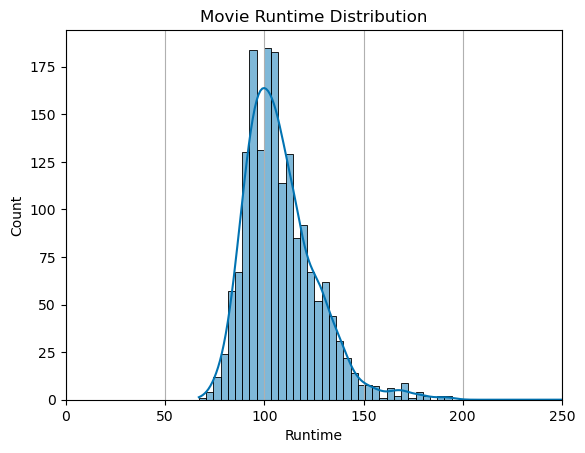

Average movie runtime (minutes):  108 ± 18
Median movie runtime (minutes):  105


In [63]:
# runtime distribution histogram
sns.histplot(data=movies_finance, x="runtime", bins="auto", kde=True)
plt.title("Movie Runtime Distribution")
plt.xlabel("Runtime")
plt.xscale("linear")
plt.grid(axis="x")
plt.xlim(0, 250)
plt.show()

print(
    "Average movie runtime (minutes): ",
    round(movies_finance["runtime"].mean()),
    "\u00B1",
    round(movies_finance["runtime"].std()),
)
print("Median movie runtime (minutes): ", round(movies_finance["runtime"].median()))

It is clear that most of the movies are between the interval [90, 120] minutes, with a mean of 107 and median of 103 minutes. It is obvious that the length has to fall into some 'pre-defined' interval. If the movie is too short, not many people will consider watching it, and if it is too long, people will eventuall lose interest.

Now, we want to see if there is a relationship between the runtime and the movie's financial success. We will plot the runtime vs. budget, revenue, profit and ROI. This way we can see in what movie runtime is the most budget invested, as well as what runtime produces highest revenue, profit and ROI.

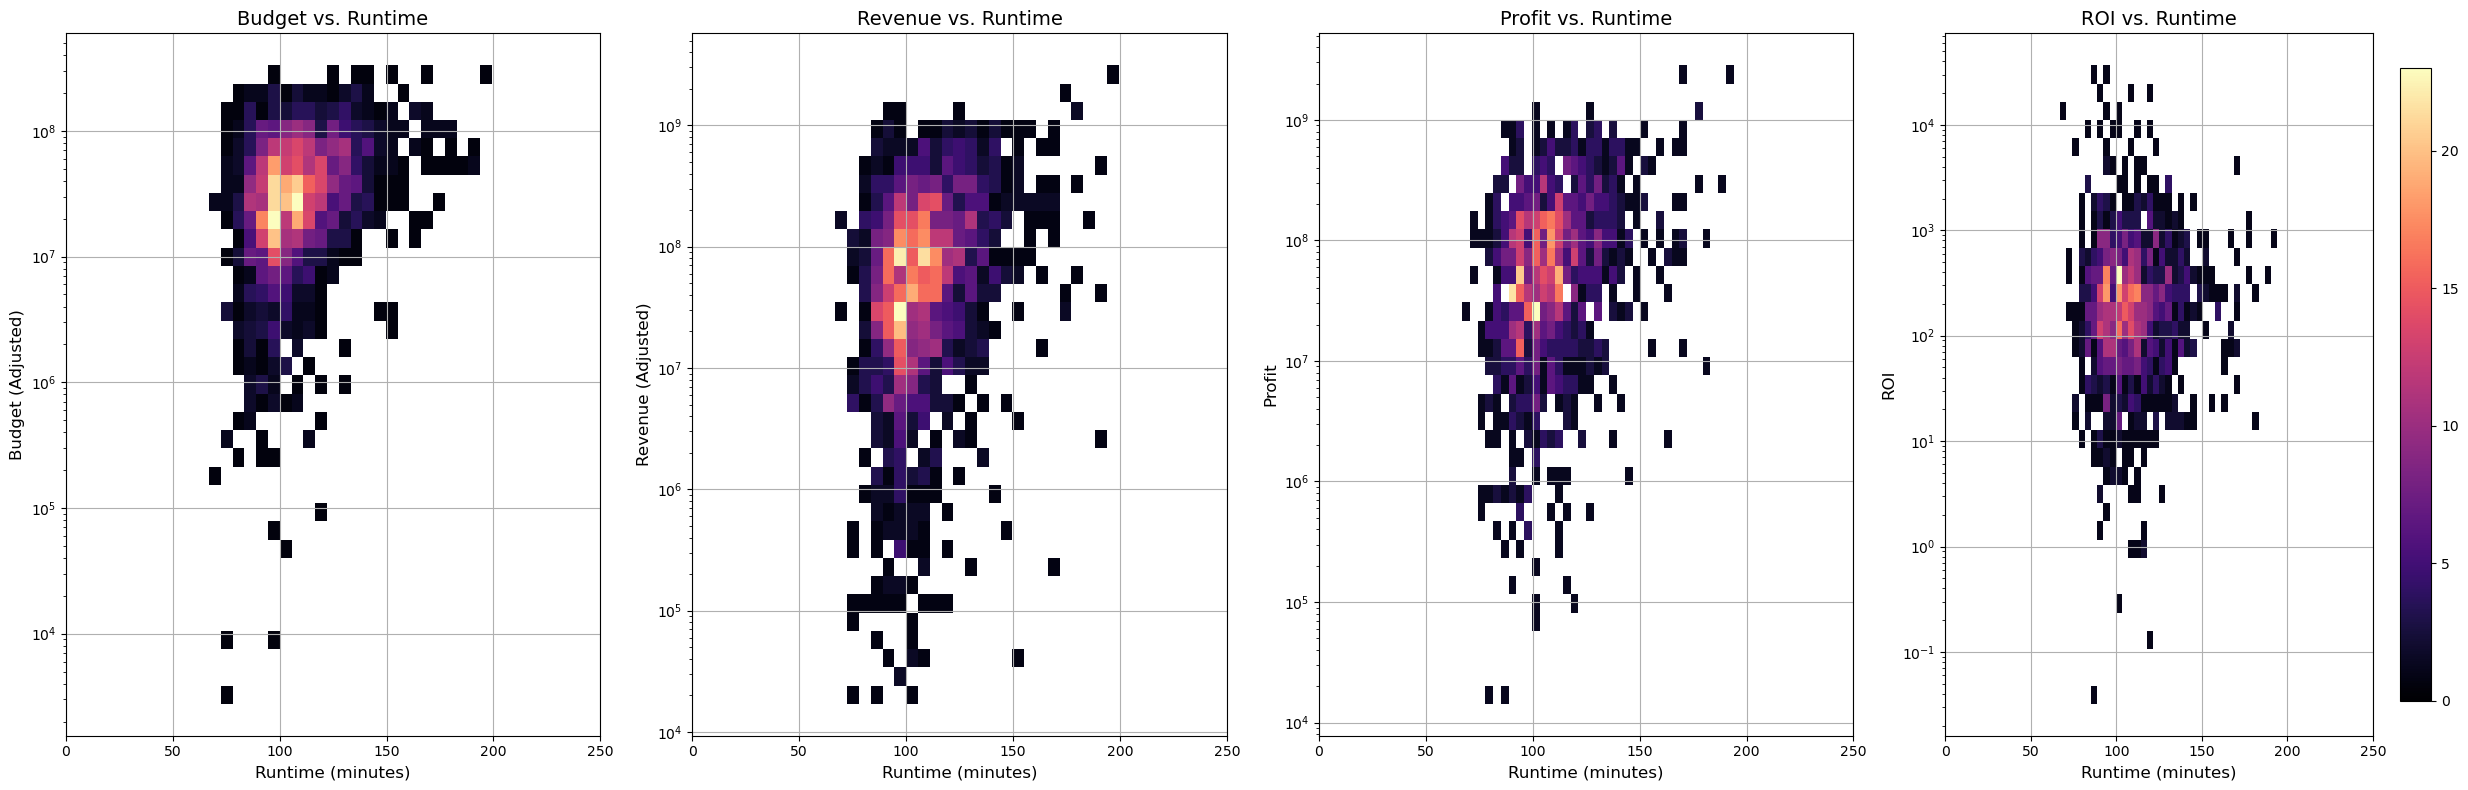

In [64]:
# plot budget, revenue and profit vs. runtime as 2d histograms
fig, axes = plt.subplots(1, 4, figsize=(25, 8))

# Budget vs. Runtime
sns.histplot(
    ax=axes[0],
    data=movies_finance,
    x="runtime",
    y="budget_adjusted",
    bins=35,
    cmap="magma",
    log_scale=(False, True),
)
axes[0].set_title("Budget vs. Runtime", fontsize=14)
axes[0].set_xlabel("Runtime (minutes)", fontsize=12)
axes[0].set_ylabel("Budget (Adjusted)", fontsize=12)
axes[0].set_xlim(0, 250)
axes[0].grid(True)

# Revenue vs. Runtime
sns.histplot(
    ax=axes[1],
    data=movies_finance,
    x="runtime",
    y="revenue_adjusted",
    bins=35,
    cmap="magma",
    log_scale=(False, True),
)
axes[1].set_title("Revenue vs. Runtime", fontsize=14)
axes[1].set_xlabel("Runtime (minutes)", fontsize=12)
axes[1].set_ylabel("Revenue (Adjusted)", fontsize=12)
axes[1].set_xlim(0, 250)
axes[1].grid(True)

# Profit vs. Runtime
sns.histplot(
    ax=axes[2],
    data=movies_finance[movies_finance["profit"] > 0],
    x="runtime",
    y="profit",
    bins=35,
    cmap="magma",
    log_scale=(False, True),
)
axes[2].set_title("Profit vs. Runtime", fontsize=14)
axes[2].set_xlabel("Runtime (minutes)", fontsize=12)
axes[2].set_ylabel("Profit", fontsize=12)
axes[2].set_xlim(0, 250)
axes[2].grid(True)

# ROI vs. Runtime
sns.histplot(
    ax=axes[3],
    data=movies_finance[movies_finance["roi"] > 0],
    x="runtime",
    y="roi",
    bins=35,
    cbar=True,
    cbar_kws={"shrink": 0.9},
    cmap="magma",
    log_scale=(False, True),
)
axes[3].set_title("ROI vs. Runtime", fontsize=14)
axes[3].set_xlabel("Runtime (minutes)", fontsize=12)
axes[3].set_ylabel("ROI", fontsize=12)
axes[3].set_xlim(0, 250)
axes[3].grid(True)

plt.tight_layout()
plt.show()

We can easily connect the initial runtime distribution plot and the following 4 plots. It was shown that the average movie length was in the interval [90, 120], and with these plots we can see that most of the budget, revenue, profit and ROI also fall in this interval. Looking a bit closer into the hue of the 2D histogram plots, we can see that the highest values usually correspond to length of 100 minutes. In order to statistically compare the variables and runtime, we turn to the Spearman correlation test.

In [65]:
# Spearmann correlation between runtime and budget, revenue and profit
print(
    "Spearman Correlation between runtime and budget: ",
    stats.spearmanr(movies_finance["runtime"], movies_finance["budget_adjusted"]),
)
print(
    "Spearman Correlation between runtime and revenue: ",
    stats.spearmanr(movies_finance["runtime"], movies_finance["revenue_adjusted"]),
)
print(
    "Spearman Correlation between runtime and profit: ",
    stats.spearmanr(movies_finance["runtime"], movies_finance["profit"]),
)
print(
    "Spearman Correlation between runtime and ROI: ",
    stats.spearmanr(movies_finance["runtime"], movies_finance["roi"]),
)

Spearman Correlation between runtime and budget:  SignificanceResult(statistic=0.31731757036107716, pvalue=4.5264092153197776e-42)
Spearman Correlation between runtime and revenue:  SignificanceResult(statistic=0.3013580071769405, pvalue=6.398004389404881e-38)
Spearman Correlation between runtime and profit:  SignificanceResult(statistic=0.20218302505785563, pvalue=1.5533541967716372e-17)
Spearman Correlation between runtime and ROI:  SignificanceResult(statistic=0.09567709482064925, pvalue=6.313873827854533e-05)


We will try to characterize each statistical test individually to try to explain the results:
1. **Runtime vs. Budget**
    - We can see that runtime and budget are positively correlated, but with a weak correlation coefficient. Logically, the correlation is positive because the longer the movie is, the more money is needed to produce it. The statistic is not very strong, meaning that the budget is not the only factor that determines the runtime of a movie.
2. **Runtime vs. Revenue**
    - Similarly to the previous test, runtime and revenue are positively correlated, but with a weak correlation coefficient. This means that the longer the movie is, the more revenue it will generate. Since budget and runtime are positively correlated (proven in previous section), it comes by induction that the longer the movies is, the higher the budget, thus, the higher the revenue.
3. **Runtime vs. Profit**
    - Based again on previous analysis it is now clear that the profit will increase as budget and revenue increase accordingly (remind the definition of profit!). Again, the correlation is weak, meaning that the runtime is not the only factor that determines the profit of a movie. 
4. **Runtime vs. ROI**
    - We introdcued ROI specifically for analysis of this kind. As ROI shows real rate of return, we can clearly see that the movie runtime minimally impacts it. This is also evident from the weak correlation coefficient. We can conclude that the runtime is not a statistically significant factor that determines the ROI of a movie.

Thinking about the results, they might seem counter-intuitive. The issue with the first 3 tests is that movie runtime cannot be infinite and is upper-bounded. This means that the runtime cannot be arbitrarily large, and therefore the budget, revenue and profit cannot be arbitrarily large. This is why we see a weak correlation between runtime and the other variables. However, ROI is a relative measure and is not upper-bounded and clearly shows that given our dataset, runtime almost does not impact the financial success of a movie.

For example, if we plot again as a scatter plot the relation between runtime and profit, we can see that the correlation is weak, but the trend is linearly and monotonically increasing. This means that the longer the movie is, the higher the profit, technically reaching an infinite value for the profit. However, this is not the case for ROI, as it can be seen on the other plot, which is a nearly stable line.

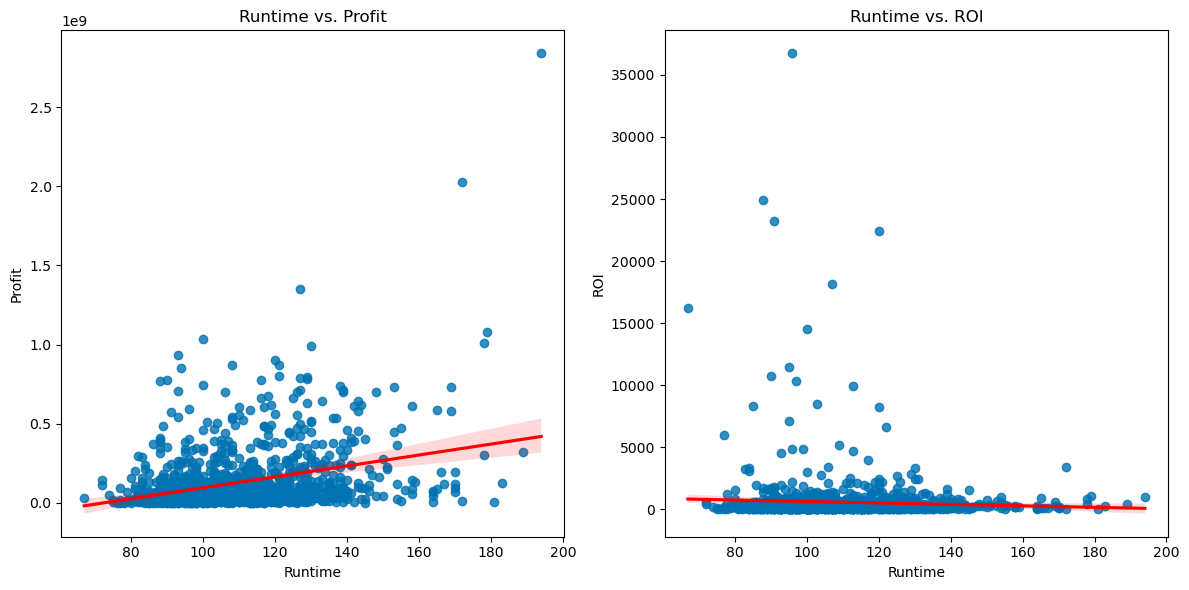

In [66]:
# scatter plot of runtime vs. profit and runtimve vs. roi
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(
    ax=axes[0],
    data=movies_finance[movies_finance["profit"] > 0],
    x="runtime",
    y="profit",
    ci=95,
    line_kws={"color": "red"},
)
sns.regplot(
    ax=axes[1],
    data=movies_finance[movies_finance["roi"] > 0],
    x="runtime",
    y="roi",
    ci=95,
    line_kws={"color": "red"},
)
axes[0].set_title("Runtime vs. Profit")
axes[1].set_title("Runtime vs. ROI")
axes[0].set_xlabel("Runtime")
axes[0].set_ylabel("Profit")
axes[1].set_xlabel("Runtime")
axes[1].set_ylabel("ROI")
plt.tight_layout()
plt.show()

One more way to summarize the above-mentioned comments is to perform a regression task in which we try to estimate the profit of a movie based on its runtime. We will use the Ordinary Least Squares (OLS) method to fit a linear regression model to the data.

In [67]:
# fit a linear regression model for profit vs. runtime
reg = smf.ols(
    formula="profit ~ runtime",
    data=movies_finance,
).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     148.4
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           8.23e-33
Time:                        16:16:50   Log-Likelihood:                -35492.
No. Observations:                1743   AIC:                         7.099e+04
Df Residuals:                    1741   BIC:                         7.100e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.105e+08   2.44e+07     -8.645      0.0

Immediately noticeable is the very small R-squared value of 0.078 which is a good implication that the runtime is not a good predictor of the profit. Based on the comments before regarding ROI, we should expect an even smaller R-squared for the model explaining ROI vs. runtime.

In [68]:
# fit a linear regression model for roi vs. runtime
reg2 = smf.ols(
    formula="roi ~ runtime",
    data=movies_finance,
).fit()
print("R-squared = " + str(reg2.rsquared))

R-squared = 0.001011030435966953


Our personal remark and opinion is that a movie runtime is not specifically chosen to characterize and predict the financial success of a movie. It is rather chosen to fit the movie's plot and storyline and to make it more interesting for the audience and their preference. However, we cannot deny that the runtime is a factor that impacts the financial success of a movie, but it is not the only one and is a very minimal one. We will try to explore other factors that contribute to the movie's financial success in the subsequent sections.

### Movie Ratings

In this part we take a short glance at movie ratings and their impact on the movie's financial success. We will use the IMDB rating as a measure of the movie's quality and popularity. We do not put a strong emphasis on this part as ratings are given after the movie has been released and thus making some analyses biased. However, we will still try to display some interesting observations by doing exploratory data analysis.

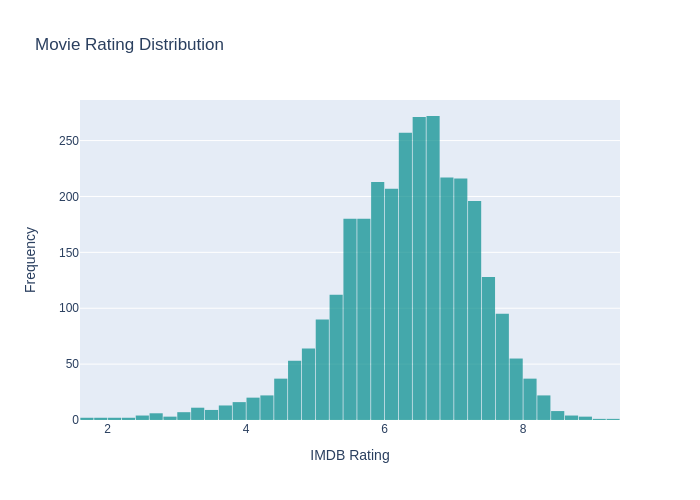

Average movie rating:  6.26


In [107]:
# plot the histogram of movie ratings
hist_trace = go.Histogram(
    x=movies["imdb_rating"],
    nbinsx=60,
    marker=dict(color="darkcyan"),
    opacity=0.7,
)

# Set layout properties
layout = go.Layout(
    title="Movie Rating Distribution",
    xaxis=dict(title="IMDB Rating"),
    yaxis=dict(title="Frequency"),
    bargap=0.05
)

# Create the figure
fig = go.Figure(data=[hist_trace], layout=layout)
fig.write_html("plots/q3_imdb_rating_distribution.html")

pio.show(fig, renderer='png')

# Print the average rating
print("Average movie rating: ", round(movies["imdb_rating"].mean(), 2))

We can observe that movies can have a rating between 1 and 10, with most movies having a rating between 6 and 7. We assume that once enough people have watched and rated the movie, the rating converges to a true value, despite different people having different opinions on those movies. This is because the number itself does not categorize the movie completely, as we cannot put a word label to describe movie based on its rating. Therefore, every person interprets the ratings differently: to someone a rating of 7 might be a good movie, while to someone else it might be a bad movie. However, we take these ratings for granted and continue our analysis.

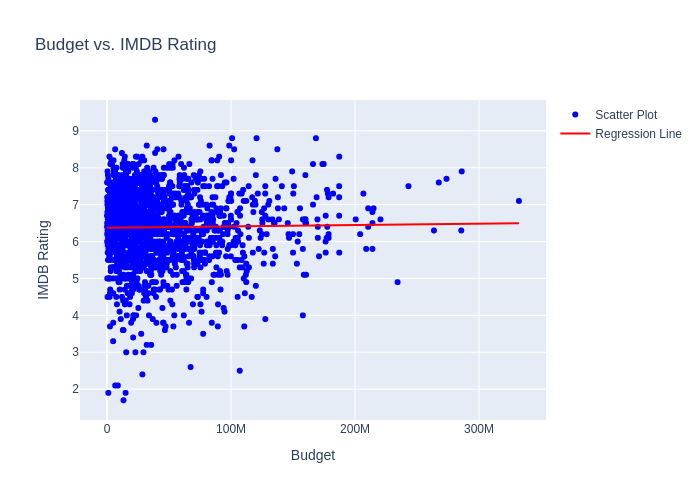

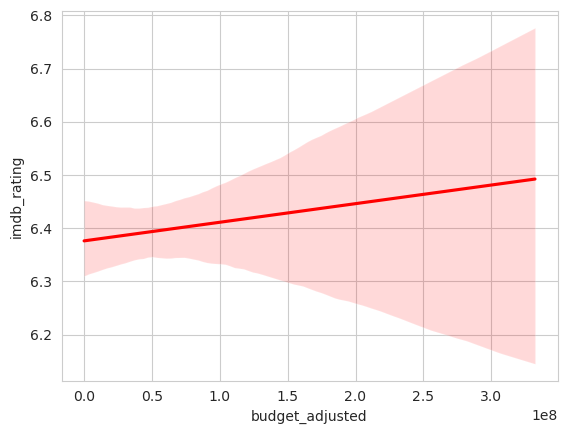

In [113]:
# plot budget vs rating
scatter_trace = go.Scatter(
    x=movies_with_budget["budget_adjusted"],
    y=movies_with_budget["imdb_rating"],
    mode="markers",
    marker=dict(color="blue"),
    name="Scatter Plot"
)

# Calculate regression line
regression_line = sns.regplot(
    data=movies_with_budget,
    x="budget_adjusted",
    y="imdb_rating",
    line_kws={"color": "red"},
    scatter=False,
).get_lines()[0].get_data()

# Regression line plot
regression_trace = go.Scatter(
    x=regression_line[0],
    y=regression_line[1],
    mode="lines",
    line=dict(color="red"),
    name="Regression Line"
)

# Set layout properties
layout = go.Layout(
    title="Budget vs. IMDB Rating",
    xaxis=dict(title="Budget"),
    yaxis=dict(title="IMDB Rating"),
)

# Create the figure
fig = go.Figure(data=[scatter_trace, regression_trace], layout=layout)
fig.write_html("plots/q3_budget_vs_rating.html")

# Show the interactive plot
pio.show(fig, renderer='png')

The only prediction we can possibly calculate given our dataset, is to predict the movie rating given its budget. This is because the budget is settled before the movie is released and does not depend on the movie's performance. As expected, given the almost-horizontal regression line, for any value of the budget we expect that the movie will be rated around the movie ratings average (calculated in previous section). Given this plot, we cannot estimate the rating of the movie given only the budget.

In this part, we try to capture the relationship between the release year and the rating. How does the rating trend change over time?

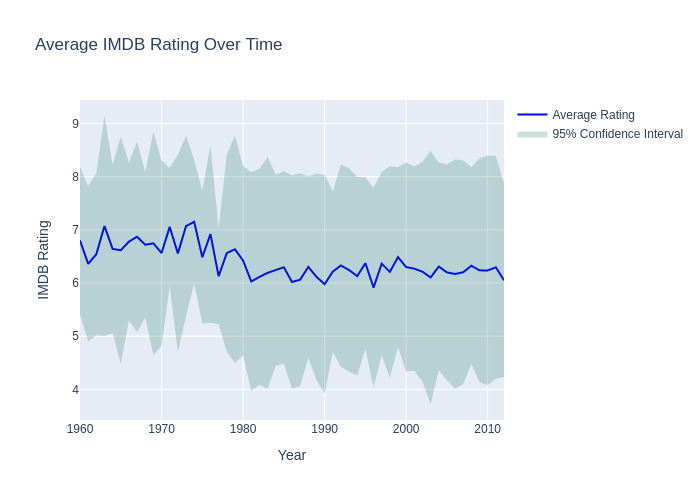

In [115]:
# lineplot with average rating for each year with 95% confidence interval
avg_rating = movies.groupby(pd.to_datetime(movies["year"]))["imdb_rating"].mean()
ci_lower = (
    avg_rating
    - 1.96 * movies.groupby(pd.to_datetime(movies["year"]))["imdb_rating"].std()
)
ci_upper = (
    avg_rating
    + 1.96 * movies.groupby(pd.to_datetime(movies["year"]))["imdb_rating"].std()
)

# Create line plot for average rating
line_trace = go.Scatter(
    x=avg_rating.index,
    y=avg_rating,
    mode="lines",
    name="Average Rating",
    line=dict(color="blue"),
)

# Create shaded area for confidence interval
ci_trace = go.Scatter(
    x=avg_rating.index.append(avg_rating.index[::-1]),
    y=pd.concat([ci_upper, ci_lower[::-1]]),
    fill="toself",
    fillcolor="rgba(0,100,80,0.2)",
    line=dict(color="rgba(255,255,255,0)"),  # Set line color to transparent
    name="95% Confidence Interval",
)

# Set layout properties
layout = go.Layout(
    title="Average IMDB Rating Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="IMDB Rating"),
)

# Create the figure
fig = go.Figure(data=[line_trace, ci_trace], layout=layout)
fig.write_html("plots/q3_avg_rating_over_time.html")

# Show the interactive plot
pio.show(fig, renderer='png')

It can still be observed that the average rating between years falls between 6 and 7. However, we can see that the average rating is slightly decreasing over time. There might have been tons of different reasons to why that is the case, and we leave it for additional anlysis to explore this correlation.

As a final exploration, we try to group the best and worst rated movies for each year and compare their profit gaps. How much financially better are the best rated movies compared to the worst rated movies?

In [72]:
best_rated_movies = (
    movies_finance.groupby("year")
    .apply(lambda x: x.nlargest(1, "imdb_rating"))
    .reset_index(drop=True)
)
worst_rated_movies = (
    movies_finance.groupby("year")
    .apply(lambda x: x.nsmallest(1, "imdb_rating"))
    .reset_index(drop=True)
)
best_worst_rated_movies = pd.merge(
    best_rated_movies, worst_rated_movies, on="year", suffixes=("_best", "_worst")
)
best_worst_rated_movies["profit_gap"] = (
    abs(best_worst_rated_movies["profit_best"] / best_worst_rated_movies["profit_worst"])
)
# filter out movies that are best and worst simultaneously (lack of movies in dataset)
best_worst_rated_movies = best_worst_rated_movies[best_worst_rated_movies["profit_gap"] != 1]
best_worst_rated_movies = best_worst_rated_movies[best_worst_rated_movies["profit_gap"] != 0]

display(
    best_worst_rated_movies[
        ["year", "title_best", "title_worst", "imdb_rating_best", "imdb_rating_worst", "profit_gap"]
    ].sort_values(by=["profit_gap"], ascending=False).head(3)
)
display(
    best_worst_rated_movies[
        ["year", "title_best", "title_worst", "imdb_rating_best", "imdb_rating_worst", "profit_gap"]
    ].sort_values(by=["profit_gap"], ascending=True).head(3)
)
# print mean profit gap
print("Mean profit gap: ", round(best_worst_rated_movies["profit_gap"].mean(), 2))

,year,title_best,title_worst,imdb_rating_best,imdb_rating_worst,profit_gap
13,1973,The Sting,The Crazies,8.3,6.1,1174.523892
40,2000,Gladiator,Dungeons & Dragons,8.5,3.6,297.369699
25,1985,Back to the Future,Gymkata,8.5,4.3,131.752125


,year,title_best,title_worst,imdb_rating_best,imdb_rating_worst,profit_gap
45,2005,Serenity,BloodRayne,7.8,3.0,0.006114
51,2011,Warrior,Justin Bieber: Never Say Never,8.1,1.7,0.022739
34,1994,The Shawshank Redemption,Street Fighter,9.3,4.0,0.051867


Mean profit gap:  49.66


We can see that the mean profit gap between best and worst rated movies is around 49. This means that the best rated movie generated 44 times the profit of the worst rated one. To show some concrete examples, in 1973 "The Sting" generated 1174 times the profit of "The Crazies". It is also interesting to notice that sometimes the worst rated movies can generate higher profits than the best rated ones. We believe this might be due to some other external influences (such as the popularity of the actors). For example, in 2011, "Warrior" made 0.02 the profit of "Justin Bieber: Never Say Never" despite having 6.7 points more in rating. Since Justin Bieber has a huge fanbase from his singing career, those same fans also went to watch his movie and generated revenue, despite the movie being rated with a very low rating.

In [73]:
pd.options.mode.chained_assignment = 'warn'

## Q4: Influence of Global Events on the Movie Industry

###  How have significant global events, such as the Global Financial Crisis in 2007-2008, influenced movie budgets and revenues?

#### Revenue

To answer this question we will split the data into 3 periods: before, during and after the 2007-2008 Global Financial Crisis.

In [74]:
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

# split the movies into 3 periods based on the year
before_crisis = movies[movies['year'] <= 2006]
during_crisis = movies[(movies['year'] >= 2007) & (movies['year'] <= 2008)]
after_crisis = movies[movies['year'] >= 2009]

We will visualise the mean revenue along with the 95% confidence interval for each period in order to see if there is a difference between movie revenues in these periods.

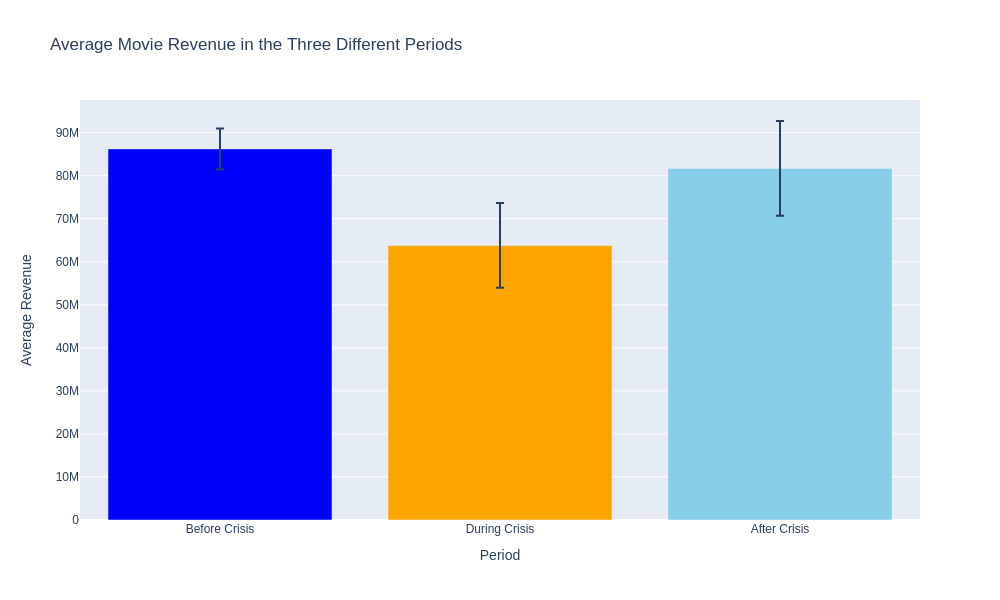

In [75]:
# calculate the mean and 95% confidence interval for the revenue in each period
mean_revenue_before = before_crisis['revenue_adjusted'].mean()
ci_revenue_before = before_crisis['revenue_adjusted'].sem() * 1.96  

mean_revenue_during = during_crisis['revenue_adjusted'].mean()
ci_revenue_during = during_crisis['revenue_adjusted'].sem() * 1.96 

mean_revenue_after = after_crisis['revenue_adjusted'].mean()
ci_revenue_after = after_crisis['revenue_adjusted'].sem() * 1.96 

periods = ['Before Crisis', 'During Crisis', 'After Crisis']
mean_revenues = [mean_revenue_before, mean_revenue_during, mean_revenue_after]
cis_revenues = [ci_revenue_before, ci_revenue_during, ci_revenue_after]
colors = ['blue', 'orange', 'skyblue']

# interactive bar chart
trace = go.Bar(
    x=periods,
    y=mean_revenues,
    error_y=dict(
        type='data', 
        array=cis_revenues,
        visible=True
    ),
    marker=dict(color=colors)
)

layout = go.Layout(
    title='Average Movie Revenue in the Three Different Periods',
    xaxis=dict(title='Period'),
    yaxis=dict(title='Average Revenue'),
    showlegend=False
)

fig = go.Figure(data=[trace], layout=layout)

fig.write_html("./plots/average_revenue_periods.html")

fig.update_layout(
    width=1000, 
    height=600  
)
pio.show(fig, renderer='png')


We can see that the mean revenue of the movies released during the crisis is lower than the mean revenue of the movies released before and after the crisis.
So, we will perform an ANOVA test to see if the difference is statistically significant.

In [76]:
anova_revenue = f_oneway(before_crisis['revenue_adjusted'], 
                during_crisis['revenue_adjusted'], 
                after_crisis['revenue_adjusted'])

print("\nANOVA Test Results:")
print(anova_revenue)


ANOVA Test Results:
F_onewayResult(statistic=5.371816765858013, pvalue=0.00466434998730726)


Since the p-value is lower than 0.05 we can reject the null hypothesis that the mean revenues of the movies for the three periods are equal. 

We will do further post-hoc analysis to determine which specific groups are different from each other.

In [77]:
before_crisis.loc[:, 'period'] = 'Before'
during_crisis.loc[:, 'period'] = 'During'
after_crisis.loc[:, 'period'] = 'After'

# concatenate the DataFrames into one
combined_data = pd.concat([before_crisis, during_crisis, after_crisis], ignore_index=True)

# perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=combined_data['revenue_adjusted'], 
                          groups=combined_data['period'],          
                          alpha=0.05)                               

print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
group1 group2    meandiff    p-adj      lower          upper     reject
-----------------------------------------------------------------------
 After Before   4534704.2038 0.7139  -9052636.6277 18122045.0352  False
 After During -17897359.0609 0.0803 -37420161.9832  1625443.8614  False
Before During -22432063.2646 0.0032 -38549450.2837 -6314676.2456   True
-----------------------------------------------------------------------


The only significant difference found by Tukey's HSD test is between the movies before and during the crisis period, indicating that the financial crisis had a significant impact on movie revenues when comparing these two periods. 

However, it's important to mention that while Tukey's HSD test revealed a significant difference in movie revenues between the before and during the crisis periods, this finding doesn't necessarily imply a direct cause-and-effect relationship solely due to the financial crisis and several other factors could also influence this observed difference.

#### Budget

We will do a similar analysis for the budget of movies before, during and after the 2007-2008 Global Financial Crisis.

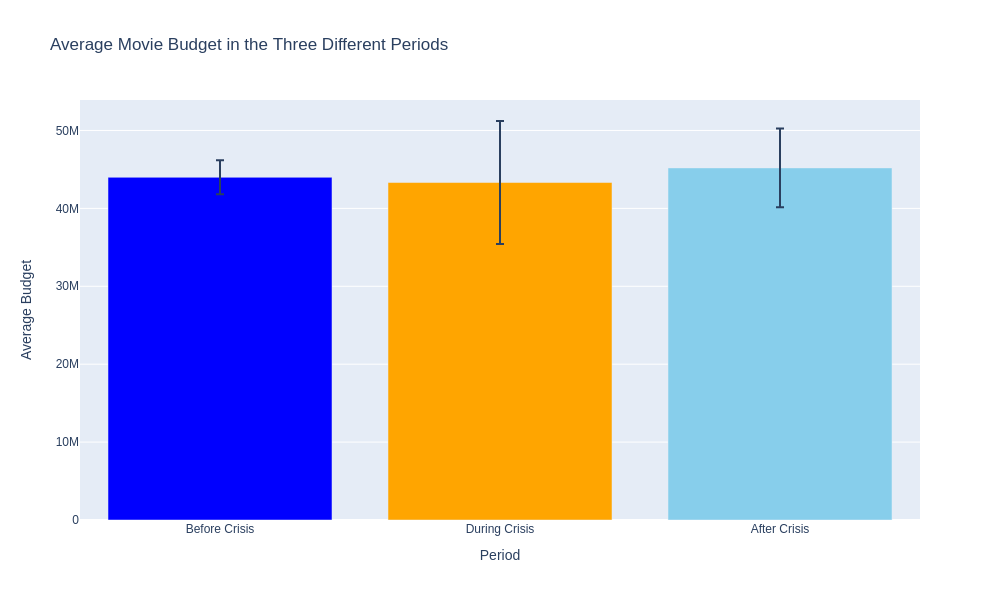

In [78]:
# calculate the mean and 95% confidence interval for the budget in each period
mean_budget_before = before_crisis['budget_adjusted'].mean()
ci_budget_before = before_crisis['budget_adjusted'].sem() * 1.96  

mean_budget_during = during_crisis['budget_adjusted'].mean()
ci_budget_during = during_crisis['budget_adjusted'].sem() * 1.96  

mean_budget_after = after_crisis['budget_adjusted'].mean()
ci_budget_after = after_crisis['budget_adjusted'].sem() * 1.96  

periods = ['Before Crisis', 'During Crisis', 'After Crisis']
mean_budgets = [mean_budget_before, mean_budget_during, mean_budget_after]
cis_budgets = [ci_budget_before, ci_budget_during, ci_budget_after]
colors = ['blue', 'orange', 'skyblue']

# interactive bar chart
trace = go.Bar(
    x=periods,
    y=mean_budgets,
    error_y=dict(
        type='data', 
        array=cis_budgets,
        visible=True
    ),
    marker=dict(color=colors)
)

layout = go.Layout(
    title='Average Movie Budget in the Three Different Periods',
    xaxis=dict(title='Period'),
    yaxis=dict(title='Average Budget'),
    showlegend=False
)

fig = go.Figure(data=[trace], layout=layout)

fig.write_html("./plots/average_budget_periods.html")

fig.update_layout(
    width=1000, 
    height=600  
)
pio.show(fig, renderer='png')


The plot indicates that movie budgets are the highest after the financial crisis. Contrary to the revenue, here there is a much smaller decrease during the crisis. The overlapping confidence intervals imply that while there is 'a trend' in budget changes, the differences may not be statistically significant without further analysis, so we will again perform an ANOVA test to see if the difference is statistically significant.

In [79]:
anova = f_oneway(before_crisis['budget_adjusted'].dropna(), 
                during_crisis['budget_adjusted'].dropna(), 
                after_crisis['budget_adjusted'].dropna())

print("\nANOVA Test Results:")
print(anova)


ANOVA Test Results:
F_onewayResult(statistic=0.1488044615545573, pvalue=0.8617485663149982)


The p-value of 0.861 is higher than 0.05 and indicates that there are no statistically significant differences in the mean budgets of movies before, during, and after the financial crisis. 

## Q5: Correlation Between Movie Content and Financial Success

### Are money-related movies more frequent after the Global Financial Crisis?

Before we answer this question, we have to retrieve the money-related movies from the dataset. In order to do that we will perfrom `Document Retrieval` using a pretrained embedding model. We will use the Universal Sentence Encoder to create embeddings from the movie plots. Then we will create a query that represents the money-related movies and we will retrieve the top K movies that are most similar to the query. We will use the cosine similarity to measure the similarity between the query and the movies. The movies that are most similar to the query will be the movies that are most related to money. 

In [80]:
movies_with_plots.head()

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,plot,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",2001
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...,1987
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra...",1983
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns...",2002
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a...",1997


1. Clean the plots, stopword removal and lowercase.
2. Load a pretrained embedding model, and transform the processed plots to embeddings
3. Document Retrieval: Retrieve the topK plots, first define a query that captures the "money-related movies" theme, embed the query using the same pretrained model, calculate cosine similarity between the query and all the plots.

In [81]:
nltk.download("stopwords")
nltk.download("wordnet")

# preprocessing function
def preprocess_text(text):
    # lowercase
    text = text.lower()
    # remove special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text, re.I | re.A)
    # tokenization
    tokens = text.split()
    # remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return " ".join(filtered_tokens)


movies_with_plots["processed_plot"] = movies_with_plots["plot"].apply(preprocess_text)

# display
movies_with_plots[["title", "processed_plot"]].head()

[nltk_data] Downloading package stopwords to /home/stef/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/stef/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,title,processed_plot
0,Ghosts of Mars,set second half nd century film depicts mars p...
1,White Of The Eye,series murders rich young women throughout ari...
2,A Woman in Flames,eva upper class housewife becomes frustrated l...
3,The Sorcerer's Apprentice,every hundred years evil morgana returns claim...
4,Little city,adam san franciscobased artist works cab drive...


In [82]:
# load the Universal Sentence Encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


# function to create embeddings using the Universal Sentence Encoder model
def create_embeddings(texts, batch_size):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        batch_embeddings = embed(batch_texts).numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)


plot_embeddings = create_embeddings(
    movies_with_plots["processed_plot"].tolist(), batch_size=200
)

2023-12-21 16:18:43.050618: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 16:18:43.145677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 16:18:43.145969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [83]:
# most important part, defining the query
query = [
    "Economic Challenges, Recession, Crisis, Stock Market",
    "Rise and Fall in Finance",
    "Financial Crime and Scandal",
    "Wealth and Lifestyle Transformation",
    "Economic Challenges and Survival",
    "Corporate Power Dynamics",
    "Money and Moral Dilemmas",
    "Personal Finance and Relationships",
    "Rags to Riches Stories",
    "Impact of Wealth on Society",
]  # we used CHAT-GPT to generate us the queries


# embed the query using the same model
query_embedding = embed(query)

# mean of the query embedding
query_embedding = np.mean(query_embedding, axis=0, keepdims=True)

# calculate cosine similarity between the query and all movie plots
cosine_similarities = cosine_similarity(query_embedding, plot_embeddings)

# get the top N movies with the highest similarity scores
top_n = 1000
top_n_indices = cosine_similarities[0].argsort()[-top_n:][::-1]

# create a dataframe for the top movies
money_related_movies = movies_with_plots.iloc[top_n_indices]

money_related_movies.head()

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,plot,year,processed_plot
9361,24564673,/m/080m72w,Qué Hombre tan Sin Embargo,1967-04-06,NaN,99.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0b90_r"": ""Mexico""}","{""/m/01z4y"": ""Comedy""}",A witty homeless man becomes the butler of an...,1967,witty homeless man becomes butler affluent fam...
19339,10393294,/m/02qbg4d,Three-Cornered Moon,1933-08-08,NaN,77.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03p5xs"": ""Comedy of manners"", ""/m/01z4y"":...",Difficulties overtake a well-to-do family in N...,1933,difficulties overtake welltodo family new york...
10368,6992578,/m/0g_b2k,The Billion Dollar Hobo,1977,NaN,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hqxf"": ""Family Film"", ""/m/01lrrt"": ""Melo...","Conway is Vernon Praiseworthy, heir to a fortu...",1977,conway vernon praiseworthy heir fortune late u...
15511,19746061,/m/04mz2r9,Moster fra Mols,1943-02-24,NaN,86.0,"{""/m/0295r"": ""Danish Language""}","{""/m/0k6nt"": ""Denmark""}","{""/m/0hqxf"": ""Family Film"", ""/m/01g6gs"": ""Blac...",A wealthy businessman and his wife deal with g...,1943,wealthy businessman wife deal gardening troubl...
16264,28353730,/m/0crgyks,Dear Mr. Prohack,1949,NaN,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02l7c8"": ""Romance Film"", ""/m/01z4y"": ""Com...",A civil servant who is extremely frugal with t...,1949,civil servant extremely frugal governments mon...


Lets visualize the most frequent words in the retrieved movies to confirm that they resolve around money, and struggle

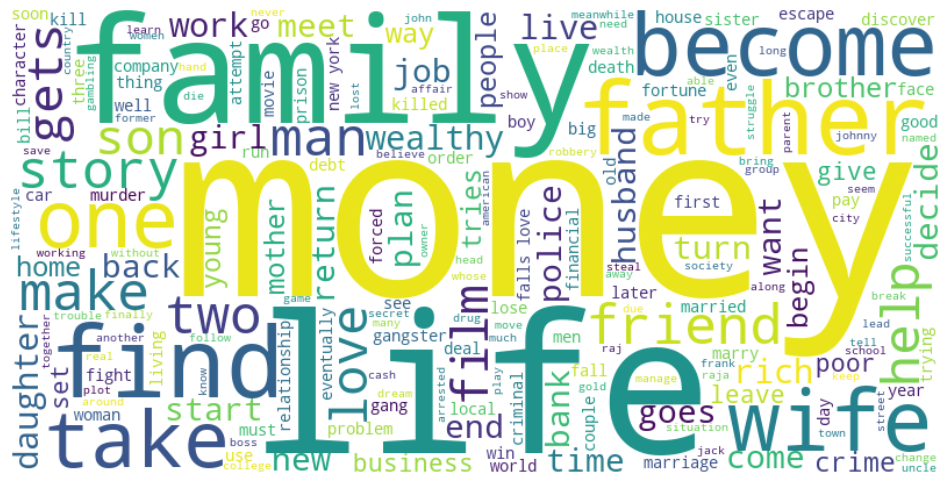

In [84]:
# from the money_relate_movies dataset visualize a word cloud of the most frequent words
from wordcloud import WordCloud

# join all the plots into one string
all_plots = " ".join(money_related_movies["processed_plot"].tolist())

# generate the word cloud
wordcloud = WordCloud(
    width=800, height=400, background_color="white", random_state=0
).generate(all_plots)

# plot the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

This wordcloud shows the most frequent words in the plots of the movies that are related to money. We can see that words like 
money, wealthy, life, financial, crime, business. This is a good sign that the model is working
as expected and that we successfully retrieved movies that are related to money.

Okay, so now that we have successfully found the movies that are money related, we need to group and count them by year, so we can visualize to determine whether there is a trend between the Global Financial Crisis and money-related movies.

In [85]:
# count the number of money-related movies by year
money_movies_count_by_year = money_related_movies.groupby("year").size()

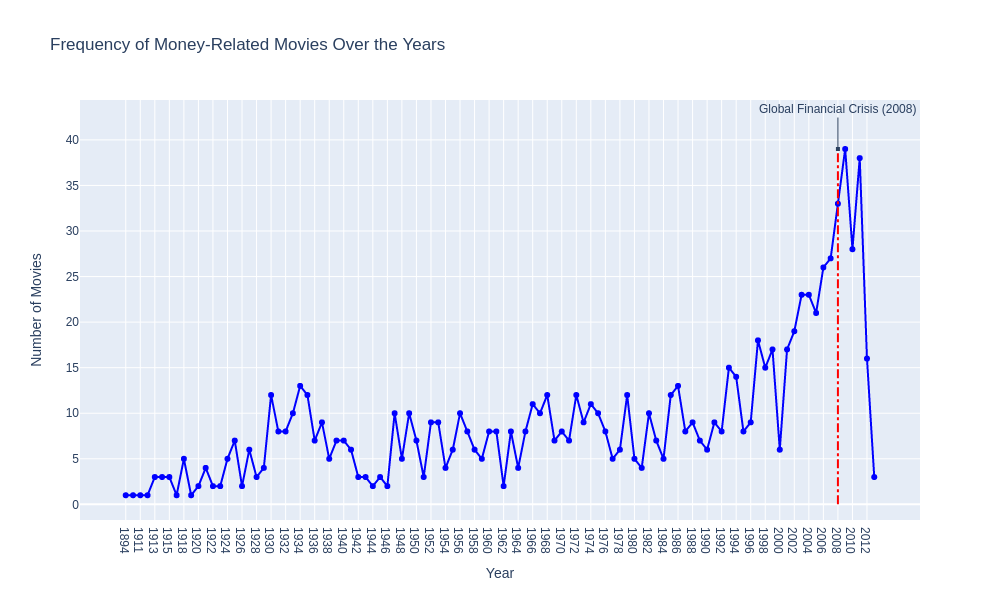

In [86]:
# create a plot to visualize the trend of money-related movies over the years
data = go.Scatter(
    x=money_movies_count_by_year.index,
    y=money_movies_count_by_year.values,
    mode="lines+markers",
    line=dict(color="blue"),
    marker=dict(color="blue"),
)

layout = go.Layout(
    title="Frequency of Money-Related Movies Over the Years",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Number of Movies"),
    shapes=[
        # line to indicate Global Financial Crisis (2008)
        dict(
            type="line",
            x0=98,
            y0=0,
            x1=98,
            y1=max(money_movies_count_by_year.values),
            line=dict(
                color="Red",
                width=2,
                dash="dashdot",
            ),
        )
    ],
    annotations=[
        dict(
            x=98,
            y=max(money_movies_count_by_year.values),
            xref="x",
            yref="y",
            text="Global Financial Crisis (2008)",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40,
        )
    ],
)

fig = go.Figure(data=[data], layout=layout)
fig.update_layout(legend=dict(y=0.5, traceorder="reversed", font_size=16))
fig.write_html("plots/money_movies_over_time.html")

fig.update_layout(
    width=1000, 
    height=600  
)
pio.show(fig, renderer='png')

We can see a clear spike after the year of 2008, lets zoom in to see the changes more clearly.

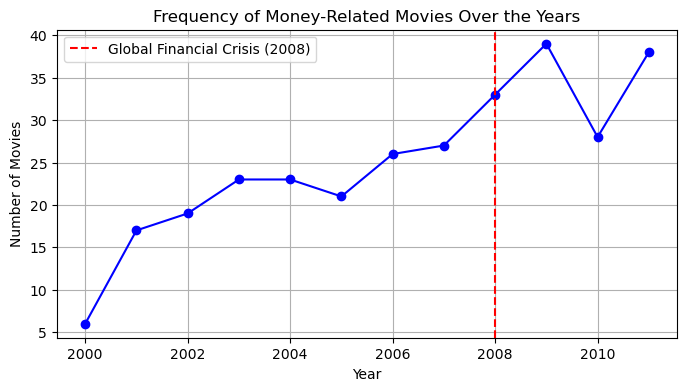

In [87]:
# zoom in on the years around 2008
plt.figure(figsize=(8, 4))
money_movies_count_by_year.loc["2000":"2011"].plot(
    kind="line", color="blue", marker="o"
)
plt.title("Frequency of Money-Related Movies Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.axvline(x=8, color="red", linestyle="--", label="Global Financial Crisis (2008)")
plt.legend()
plt.grid(True)
plt.show()

From the graphs we can see that money-related movies tend to increase over the years. We can also see a spike in the number of money-related movies around 2008, which is the year of the Global Financial Crisis. This is expected since the crisis was a major event that affected the whole world and it is natural that it would be reflected in the movie industry as well. However notice that there is a lag from 1-2 years for the production of money-related movies to spike. This might be due to the fact that movies take 1-2 years from production to deployment. See [How Long Does It Take to Film a Movie?](https://www.backstage.com/magazine/article/how-long-does-it-take-to-film-a-movie-76171/).

Next, we will compare the frequency of money-related movies to the overall number of movies produced each year. This will allow us to determine whether there is a significant increase in the proportion of money-related movies, rather than just an increase in absolute numbers, which could be due to an overall increase in movie production.

In [88]:
# calculate the total number of movies produced each year
total_movies_by_year = movies_with_plots.groupby("year").size()

# calculate the proportion of money-related movies each year
proportion_money_movies = money_movies_count_by_year / total_movies_by_year

comparative_analysis_df = pd.DataFrame(
    {
        "Total Movies": total_movies_by_year,
        "Money-Related Movies": money_movies_count_by_year,
        "Proportion of Money-Related": proportion_money_movies,
    }
)

# display from 2000 to 2012
comparative_analysis_df.loc["2000":"2012"]

,Total Movies,Money-Related Movies,Proportion of Money-Related
year,,,
2000,782,6.0,0.007673
2001,839,17.0,0.020262
2002,947,19.0,0.020063
2003,1062,23.0,0.021657
2004,1117,23.0,0.020591
2005,1272,21.0,0.016509
2006,1527,26.0,0.017027
2007,1527,27.0,0.017682
2008,1615,33.0,0.020433


The reason we chose this time frame is because we want to see the 
effect of the 2008 financial crisis on the proportion of money related movies. If we look at a larger period there is the risk of other 
financial crises affecting the proportion of money related movies.

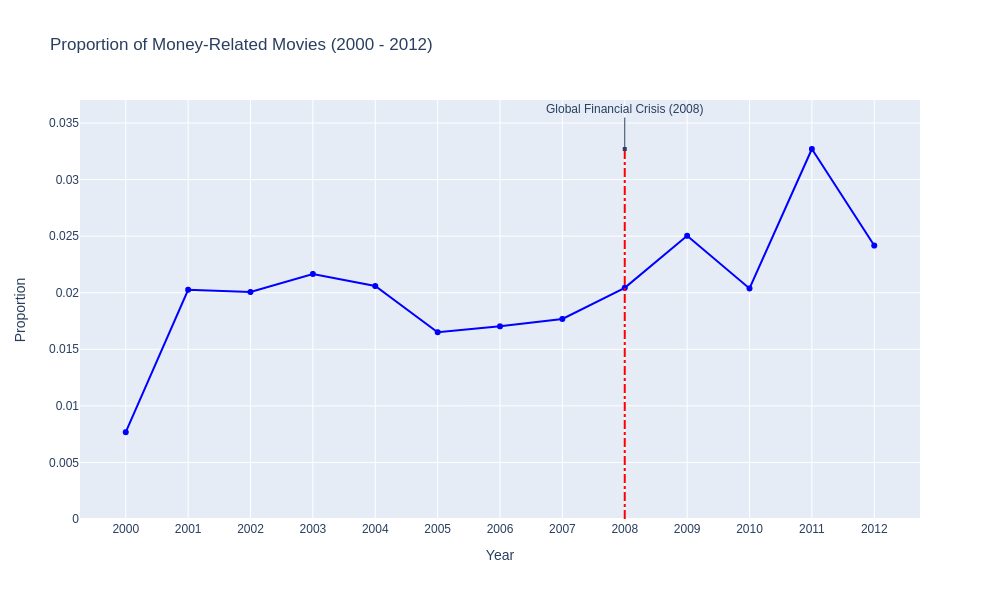

In [89]:
# Assuming 'comparative_analysis_df' is a DataFrame with years as index
# and contains a column 'Proportion of Money-Related' for the specified years
filtered_data = comparative_analysis_df.loc["2000":"2012"][
    "Proportion of Money-Related"
]

data = go.Scatter(
    x=filtered_data.index,
    y=filtered_data.values,
    mode="lines+markers",
    line=dict(color="blue"),
    marker=dict(color="blue"),
)

layout = go.Layout(
    title="Proportion of Money-Related Movies (2000 - 2012)",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Proportion"),
    shapes=[
        # Line to indicate Global Financial Crisis (2008)
        dict(
            type="line",
            x0=8,
            y0=0,
            x1=8,
            y1=max(filtered_data.values),
            line=dict(
                color="Red",
                width=2,
                dash="dashdot",
            ),
        )
    ],
    annotations=[
        dict(
            x=8,
            y=max(filtered_data.values),
            xref="x",
            yref="y",
            text="Global Financial Crisis (2008)",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40,
        )
    ],
)

fig = go.Figure(data=[data], layout=layout)
fig.update_layout(legend=dict(y=0.5, traceorder="reversed", font_size=16))
fig.write_html("plots/proportion_money_movies_over_time.html")

fig.update_layout(
    width=1000, 
    height=600  
)
pio.show(fig, renderer='png')

This plot shows the proportion of money related movies from 2000 to 2012. We can see that the proportion of money related movies increases
significantly after the 2008 financial crisis. This is an interesting finding, since it shows that the financial crisis had an important
impact on the movie industry.

## Q6: Predictive Analysis of Movie Revenue

### Can a regression model using variables like budget, GDP, country, runtime, and release year effectively predict a movie's revenue?

In [90]:
movies_q6 = movies_finance.copy(deep = 'true')

#### Feature Engineering

1.1- Dropping features:

Columns like wikipedia_id, freebase_movie_id, and imdb_id are unique identifiers for each movie. These identifiers don't have predictive power for the target variable (revenue, they are unique to each record.

Primary_title and Original_title columns are redundant since we also have a title column. This data can unnecessarily increase the complexity of the model without providing additional value.

In [91]:
# list of columns to be dropped
columns_to_drop = ['wikipedia_id', 'freebase_movie_id', 'imdb_id', 'primary_title', 'original_title']

# dropping the specified columns
movies_q6.drop(columns=columns_to_drop, inplace=True)

1.2 Processing title:

In [92]:
# calculate the Length of Each Title
movies_q6['title_length'] = movies_q6['title'].apply(len)

1.3 Processing realease date

In [94]:
#function that returns number of days from the release date
from helpers import process_release_date, preprocess_movie_data, remove_unwanted_dtypes

movies_q6 = process_release_date(movies_q6, 'release_date')

1.4 Processing JSON files for : 'languages', 'countries', 'genres'

1.4.2 Processing 'languages' column

In [96]:
# count the frequency of each language
language_counts = movies_q6['languages'].value_counts()

# identify the top 10 languages
top_10_languages = language_counts.head(10).index

# filter the DataFrame to include only the top 10 languages
movies_q6 = movies_q6[movies_q6['languages'].isin(top_10_languages)]

# to process 'languages' column and one-hot encode
movies_q6 = preprocess_movie_data(movies_q6, 'languages')

1.4.2 Processing 'countries' column

In [97]:
# count the frequency of each country
countries_counts = movies_q6['countries'].value_counts()

# identify the top 10 languages
top_10_countries = countries_counts.head(10).index

# filter the DataFrame to include only the top 10 languages
movies_q6 = movies_q6[movies_q6['countries'].isin(top_10_countries)]

# to process 'countries' column and one-hot encode
movies_q6 = preprocess_movie_data(movies_q6, 'countries')

1.4.3 Process 'genres' column

In [98]:
# function to safely parse the JSON string into a dictionary
def parse_genres(genre_string):
    try:
        return json.loads(genre_string.replace("'", "\""))
    except json.JSONDecodeError:
        return {}

# apply the function to the 'genres' column
movies_q6['genres_dict'] = movies_q6['genres'].apply(parse_genres)

# extract the list of genre names
movies_q6['genre_names'] = movies_q6['genres_dict'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])

# to get a unique list of genres from the entire DataFrame
unique_genres = set()
movies_q6['genre_names'].apply(unique_genres.update)

# convert the set to a list to have a list of unique genres
unique_genres_list = list(unique_genres)

# display the unique genres list
unique_genres_list
movies_q6['genre_names']

0       [Thriller, Science Fiction, Horror, Adventure,...
1       [Costume drama, War film, Epic, Period piece, ...
2                                                      []
14      [Biography, Musical, Drama, Biopic [feature], ...
16      [Thriller, Crime Fiction, Crime Comedy, Gangst...
                              ...                        
7174                               [Crime Fiction, Drama]
7184                         [Action/Adventure, Disaster]
7185    [Thriller, Science Fiction, Action/Adventure, ...
7188    [Romantic comedy, Comedy of manners, Drama, Co...
7189    [Alien Film, Science Fiction, Family Film, Com...
Name: genre_names, Length: 1319, dtype: object

In [99]:
# list of genres to count each genre's frequency
all_genres = [genre for sublist in movies_q6['genre_names'] for genre in sublist]
genre_counts = Counter(all_genres)

#  10 most common genres and their frequencies
top_genres_with_counts = genre_counts.most_common(20)

#top 10 genres and their respective frequencies
print("Top 10 Genres and Frequencies:")
for genre, frequency in top_genres_with_counts:
    print(f"{genre}: {frequency}")

Top 10 Genres and Frequencies:
Drama: 595
Comedy: 534
Thriller: 388
Action: 326
Romance Film: 284
Action/Adventure: 232
Crime Fiction: 229
Romantic comedy: 162
Adventure: 160
Horror: 158
Science Fiction: 151
Indie: 140
Crime Thriller: 111
Mystery: 111
Fantasy: 107
Film adaptation: 97
Psychological thriller: 94
Family Film: 91
Comedy-drama: 90
Period piece: 88


In [100]:
# first, let's flatten the list of genres to count each genre's frequency
all_genres = [genre for sublist in movies_q6['genre_names'] for genre in sublist]
genre_counts = Counter(all_genres)

# find the 10 most common genres
top_10_genres = [genre for genre, count in genre_counts.most_common(20)]
top_10_genres

['Drama',
 'Comedy',
 'Thriller',
 'Action',
 'Romance Film',
 'Action/Adventure',
 'Crime Fiction',
 'Romantic comedy',
 'Adventure',
 'Horror',
 'Science Fiction',
 'Indie',
 'Crime Thriller',
 'Mystery',
 'Fantasy',
 'Film adaptation',
 'Psychological thriller',
 'Family Film',
 'Comedy-drama',
 'Period piece']

We want to minimize the number of features, so we do not want to exceed 10 features. Then, we select the most common genres that group together sub-genres

In [101]:
# filter each movie's genres to include only the top 10 genres
movies_q6['filtered_genre_names'] = movies_q6['genre_names'].apply(lambda genres: [genre for genre in genres if genre in top_10_genres])

# one-hot encode the top genres in the DataFrame, we use one hot beacause it includes multiple genres unlike dummies.
def one_hot_encode_top_genres(df, top_genres):
    # Create columns for each of the top genres with default value of 0
    for genre in top_genres:
        df['genre_' + genre] = df['filtered_genre_names'].apply(lambda genres: int(genre in genres))
    
    return df

# apply the one-hot encoding function
movies_q6 = one_hot_encode_top_genres(movies_q6, top_10_genres)

1.5 processing the other features

In [102]:
# two types movie or video
title_type_dummies = pd.get_dummies(movies_q6['title_type'], prefix='title_type')
movies_q6 = pd.concat([movies_q6, title_type_dummies], axis=1)
movies_q6.drop('title_type', axis=1, inplace=True)

In [103]:
# transform bool columns to binary columns: title_type_movie, title_type_video and is adult
for column in movies_q6.columns:
    if movies_q6[column].dtype == 'bool':
        movies_q6[column] = movies_q6[column].astype(int)

# log transform 'num_votes' and 'vote_count' since they are highly skewed
movies_q6['log_num_votes'] = np.log1p(movies_q6['num_votes'])
movies_q6['log_vote_count'] = np.log1p(movies_q6['vote_count'])

# drop the 'cpi' column since it has already been used to adjust revenue and budget
movies_q6.drop('cpi', axis=1, inplace=True)

# we choose 'revenue_adjusted' as the target and drop 'revenue'
movies_q6.drop('revenue', axis=1, inplace=True)

# use 'budget_adjusted' instead of 'budget' because we are predicting adjusted revenue
movies_q6.rename(columns={'budget_adjusted': 'budget'}, inplace=True)
movies_q6.drop('budget', axis=1, inplace=True)

# drop 'profit' and 'roi' since they are derived from 'revenue'
movies_q6.drop(['profit', 'roi'], axis=1, inplace=True)

In [104]:
# use the function to keep only the desired data types and remove the ones we processed.
desired_types = ['float64', 'int32', 'int64']
movies_q6 = remove_unwanted_dtypes(movies_q6, desired_types)

In [105]:
movies_q6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries, 0 to 7189
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   runtime                       1319 non-null   float64
 1   imdb_rating                   1319 non-null   float64
 2   num_votes                     1319 non-null   float64
 3   vote_average                  1319 non-null   float64
 4   vote_count                    1319 non-null   float64
 5   revenue_adjusted              1319 non-null   float64
 6   title_length                  1319 non-null   int64  
 7   release_year                  1319 non-null   int32  
 8   release_month                 1319 non-null   int32  
 9   release_day                   1319 non-null   int32  
 10  days_since_release            1319 non-null   int64  
 11  American English              1319 non-null   int64  
 12  Arabic Language               1319 non-null   int64  
 13  English 

In [106]:
movies_q6.head()

,runtime,imdb_rating,num_votes,vote_average,vote_count,revenue_adjusted,title_length,release_year,release_month,release_day,...,genre_Fantasy,genre_Film adaptation,genre_Psychological thriller,genre_Family Film,genre_Comedy-drama,genre_Period piece,title_type_movie,title_type_video,log_num_votes,log_vote_count
0,98.0,4.9,56918.0,4.8,299.0,1.816718e+07,14,2001,8,24,...,0,0,0,0,0,0,1,0,10.949384,5.703782
1,137.0,7.5,31200.0,7.4,73.0,1.881898e+07,7,1989,11,8,...,0,1,0,0,0,1,1,0,10.348205,4.304065
2,139.0,7.8,181780.0,7.4,1217.0,7.570509e+08,12,1964,8,27,...,0,0,0,0,0,0,1,0,12.110558,7.104965
14,176.0,6.4,2236.0,6.0,7.0,2.640275e+07,5,1968,7,18,...,0,0,0,0,0,0,1,0,7.712891,2.079442
16,115.0,6.7,29281.0,6.7,87.0,7.980572e+05,39,1995,10,1,...,0,0,0,0,0,0,1,0,10.284728,4.477337


**2-Model Building and Evalution:**

In [107]:
# assume df is your DataFrame
df = movies_q6

# features and target variable
X = df.drop(['revenue_adjusted'], axis=1)
y = df['revenue_adjusted']

# feature scaling for numerical features
scaler = StandardScaler()
numerical_features = ['runtime', 'imdb_rating', 'num_votes', 'vote_average', 'vote_count', 'title_length', 'release_year', 'days_since_release', 'log_num_votes', 'log_vote_count']  # add other numerical columns here
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize the model
model = LinearRegression()

# train the model
model.fit(X_train, y_train)

# predicting on the test set
y_pred = model.predict(X_test)

# model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 1.2111777878248098e+16
R-squared: 0.4311892717387825


TODO: Say some conclusion how this result is fine but it still wasnt what we expected ...

In [ ]:
# perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')

# calculate RMSE from cross-validation scores (take care, cross_val_score returns negative values for loss functions)
cv_rmse_scores = np.sqrt(-cv_scores)

print(f'CV RMSE scores: {cv_rmse_scores}')
print(f'CV RMSE mean: {cv_rmse_scores.mean()}')
print(f'CV RMSE standard deviation: {cv_rmse_scores.std()}')

In [ ]:
unique_genre_count = movies_q6['languages'].nunique()
print("Number of unique genres:", unique_genre_count)